# 💻 Avaliação Empírica da Regressão Logística  
**Autores**: Alexandre Furriel, Catarina Abrantes, Liliana Silva  
**Curso**: Inteligência Artificial e Ciência de Dados  
**Unidade Curricular**: Aprendizagem Computacional

In [1]:
!pip install --quiet autograd

zsh:1: command not found: pip


In [2]:
# --- Imports ---
import os
import numpy as np
import autograd.numpy as anp
from autograd import grad

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, roc_auc_score, auc
)

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# ============================
# 🔧 Funções Auxiliares
# ============================

# --- Impressão de métricas básicas ---
def print_metrics(y_true, y_pred, y_prob=None, dataset_name=""):
    # Imprime métricas de avaliação para o dataset especificado
    print(f"--- Métricas para {dataset_name} ---")
    print(f"Acurácia:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão:  {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    # Se as probabilidades forem fornecidas, informa que será usada para o cálculo de ROC/AUC
    if y_prob is not None:
        print("Nota: y_prob fornecido — usado para curva ROC/AUC.")

# --- Matriz de confusão com visualização ---
def plot_conf_matrix(y_true, y_pred, dataset_name=""):
    # Calcula matriz de confusão considerando 1 como classe positiva
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    
    # Cria o objeto de exibição da matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positiva", "Negativa"])
    
    # Plot da matriz com título
    disp.plot()
    plt.title(f"Matriz de Confusão - {dataset_name}")
    plt.show()

# --- Curva ROC com AUC ---
def plot_roc_curve(y_true, y_prob, dataset_name=""):
    # Verifica se o problema é binário
    if len(set(y_true)) > 2:
        print("Curva ROC não disponível para múltiplas classes.")
        return

    # Calcula FPR, TPR e AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot da curva ROC
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Curva ROC - {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Avaliação completa do modelo original ---
def avaliar_modelo(X, y, nome_dataset):

    print(f"\n==== Resultados para {nome_dataset} ====")

    # Divisão do dataset em treino e teste (estratificado)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Normalização dos dados (padronização z-score)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Inicializa e treina o modelo de Regressão Logística Simples
    model = SimpleLogisticRegression(lr=0.01, max_iters=5000)
    model.fit(X_train, y_train)

    # Obtém as probabilidades (scores) e converte para predição binária
    y_scores = model._predict(X_test)
    y_pred = (y_scores >= 0.5).astype(int)

    # Cálculo e exibição das métricas principais
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\nAcurácia: {acc:.4f} | Recall: {rec:.4f} | F1-score: {f1:.4f}")

    # Impressão da matriz de confusão na consola
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    print(cm)

    # Exibição gráfica da matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positiva", "Negativa"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusão: {nome_dataset}")
    plt.grid(False)
    plt.show()

    # Relatório de classificação detalhado
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Curva ROC e AUC
    try:
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot da curva ROC
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC: {nome_dataset}')
        plt.legend()
        plt.grid()
        plt.show()

        print(f"AUC: {roc_auc:.4f}")

    except Exception as e:
        # Caso haja erro no cálculo da curva ROC
        print(f"\nErro ao calcular a curva ROC: {str(e)}")

    # --- Função interna: múltiplas curvas ROC ---
    def plot_roc_multi(model_results, dataset_name=""):
        plt.figure()
        # Para cada modelo, plot da curva ROC correspondente
        for nome, y_true, y_proba in model_results:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{nome} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"Curvas ROC — {dataset_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # --- Função interna: múltiplas matrizes de confusão ---
    def plot_multiple_conf_matrices(confusion_dict, dataset_name=""):
        modelos = list(confusion_dict.keys())
        fig, axs = plt.subplots(1, len(modelos), figsize=(5 * len(modelos), 4))
        # Para cada modelo, plot da respectiva matriz
        for i, modelo in enumerate(modelos):
            disp = ConfusionMatrixDisplay(
                confusion_matrix=confusion_dict[modelo],
                display_labels=["Positiva", "Negativa"]
            )
            disp.plot(ax=axs[i], cmap="Blues", colorbar=False)
            axs[i].set_title(f"{modelo}")
        plt.suptitle(f"Matrizes de Confusão — {dataset_name}")
        plt.tight_layout()
        plt.show()


## 📘 Fundamentos Teóricos da Regressão Logística

A **regressão logística** é um modelo estatístico amplamente utilizado para tarefas de **classificação binária**, cujo objetivo é prever a probabilidade de uma instância pertencer a uma de duas classes possíveis.

O modelo assume uma **relação linear entre as variáveis preditoras** e a variável de saída transformada por uma função sigmoide. A fórmula do modelo é dada por:

\[
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{onde } z = \mathbf{w}^\top \mathbf{x} + b
\]

Aqui:
- \( \mathbf{x} \) representa o vetor de características da instância;
- \( \mathbf{w} \) são os pesos aprendidos pelo modelo;
- \( b \) é o termo de viés (*bias*), responsável por ajustar o limiar de decisão do modelo;
- \( \sigma(\cdot) \) é a função de ativação **sigmoide**, que comprime a saída para o intervalo (0, 1).

---

### 🔍 Função de Custo

O modelo é treinado através da **maximização da verosimilhança** dos dados, o que equivale a minimizar a função de custo conhecida como **entropia cruzada binária (log-loss)**:

\[
J(\theta) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
\]

Essa função penaliza fortemente predições incorretas com alta confiança, incentivando o modelo a ajustar bem as probabilidades preditas.

---

### ⚠️ Limitações em Cenários de Desbalanceamento de Classes

A regressão logística **não incorpora, por padrão, nenhum mecanismo de compensação** para classes desbalanceadas. Como cada instância contribui igualmente para a função de custo, o modelo pode minimizar o erro total **favorecendo a classe maioritária**, mesmo que isso comprometa severamente a performance sobre a minoria.

Consequentemente, é possível obter **alta acurácia global** apenas prevendo a classe dominante — um resultado enganador, sobretudo em aplicações críticas como diagnóstico médico, deteção de fraudes ou sistemas de segurança. Nesses casos, **métricas como F1-score e recall** da classe minoritária tornam-se mais relevantes que a acurácia simples.

Para lidar com essas limitações, é necessário adaptar o modelo ou sua função de perda — tema abordado nas próximas seções.



## ✅ Justificação da Escolha do Algoritmo

A **Regressão Logística** foi selecionada como algoritmo de estudo por diversas razões pertinentes tanto do ponto de vista prático como do académico:

- É um **modelo linear de classificação simples e amplamente utilizado** em contextos reais, valorizado pela sua **alta interpretabilidade** e **facilidade de implementação**.
- Permite a obtenção direta de **probabilidades associadas às predições**, o que é essencial em domínios onde os custos dos erros são assimétricos (ex.: saúde ou finanças).
- Apresenta uma **sensibilidade reconhecida ao desbalanceamento de classes**, tornando-se um **caso ideal para investigar este tipo de desafio**.
- A sua **estrutura matemática acessível** permite não só uma compreensão teórica sólida como também a **proposição e implementação de melhorias** na função de perda.

Assim, a regressão logística representa uma base robusta para **explorar os efeitos do desbalanceamento de classes** e testar abordagens de **mitigação integradas no próprio algoritmo**, como o uso de **pesos diferenciados** ou **funções de perda assimétricas**.


## ⚙️ Implementação da Regressão Logística

A seguir, apresenta-se a implementação manual da **regressão logística**, inspirada na versão open-source disponível em [rushter/MLAlgorithms](https://github.com/rushter/MLAlgorithms), com adaptações específicas.

Esta versão será utilizada como **modelo base** na análise empírica, permitindo avaliar o seu comportamento em cenários com **desbalanceamento de classes**, sem qualquer tipo de compensação ou modificação.

In [ ]:
class SimpleLogisticRegression:
    """
    Implementação de Regressão Logística Binária usando Gradiente Descendente.
    Inclui suporte opcional para regularização L2.
    """

    def __init__(self, lr=0.01, penalty="none", C=0.01, tolerance=1e-4, max_iters=1000):
        # Parâmetros do modelo
        self.lr = lr                      # Taxa de aprendizagem
        self.penalty = penalty            # Tipo de penalização: "none" ou "l2"
        self.C = C                        # Intensidade da regularização L2
        self.tolerance = tolerance        # Critério de paragem (convergência)
        self.max_iters = max_iters        # Número máximo de iterações
        self.theta = None                 # Vetor de pesos (parâmetros do modelo)

    def _add_intercept(self, X):
        # Adiciona uma coluna de 1s para representar o termo de interceção (bias)
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def _sigmoid(self, z):
        # Função sigmoide: mapeia valores reais para o intervalo (0, 1)
        return 1 / (1 + np.exp(-z))

    def _loss(self, h, y, theta):
        # Calcula a função de custo (log-loss) com regularização L2 opcional
        epsilon = 1e-15  # evita log(0)
        h = np.clip(h, epsilon, 1 - epsilon)  # estabiliza os valores de h

        # Custo da regressão logística
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

        # Se L2 estiver ativado, adiciona o termo de penalização
        if self.penalty == "l2":
            loss += self.C * np.sum(theta**2)
        return loss

    def fit(self, X, y):
        # Treina o modelo usando gradiente descendente
        X = self._add_intercept(X)  # adiciona o bias
        y = np.asarray(y).reshape(-1, 1)  # garante que y tenha formato coluna
        self.theta = np.zeros((X.shape[1], 1))  # inicializa os pesos com zeros

        for _ in range(self.max_iters):
            # Cálculo das predições (hipótese)
            z = np.dot(X, self.theta)
            h = self._sigmoid(z)

            # Cálculo do gradiente
            gradient = np.dot(X.T, (h - y)) / y.shape[0]

            # Adiciona regularização L2, se configurada
            if self.penalty == "l2":
                gradient += 2 * self.C * self.theta

            # Atualização dos pesos (regra do gradiente)
            prev_theta = self.theta.copy()
            self.theta -= self.lr * gradient

            # Critério de convergência: se o vetor de pesos mudar pouco, para
            if np.linalg.norm(self.theta - prev_theta) < self.tolerance:
                break

    def predict_proba(self, X):
        # Retorna as probabilidades estimadas para cada exemplo
        X = self._add_intercept(X)
        return self._sigmoid(np.dot(X, self.theta)).ravel()  # vetor 1D

    def predict(self, X):
        # Converte probabilidades em rótulos binários (0 ou 1) usando limiar de 0.5
        return (self.predict_proba(X) >= 0.5).astype(int)

    def _predict(self, X):
        # Versão interna compatível com funções auxiliares do notebook
        return self.predict_proba(X)


## 🧪 Avaliação Empírica com 20 Datasets Desbalanceados

Para analisar o impacto do desbalanceamento de classes na performance da regressão logística, utilizámos **20 datasets binários** com diferentes níveis de desbalanceamento. Estes datasets estão localizados na pasta `class_imbalance`.

Nesta fase, avaliamos o comportamento do **modelo base (regressão logística simples)** sem qualquer tipo de modificação.

As seguintes métricas foram recolhidas:
- Acurácia
- Recall macro
- F1-score macro
- AUC (quando aplicável)

Abaixo apresentamos os resultados obtidos para cada dataset:

- O primeiro gráfico mostra, de forma agrupada, todas as métricas por dataset.
- Em seguida, são apresentados gráficos individuais para cada métrica, permitindo uma comparação mais detalhada.

Estas visualizações permitem verificar, por exemplo, que embora a acurácia seja geralmente elevada, o **recall e o F1-score macro** são muitas vezes baixos, indicando fraco desempenho na identificação da classe minoritária.


📊 Médias por métrica (modelo Original):


Accuracy            0.9191
Recall (Macro)      0.6906
F1-Score (Macro)    0.7101
AUC                 0.8709
dtype: float64

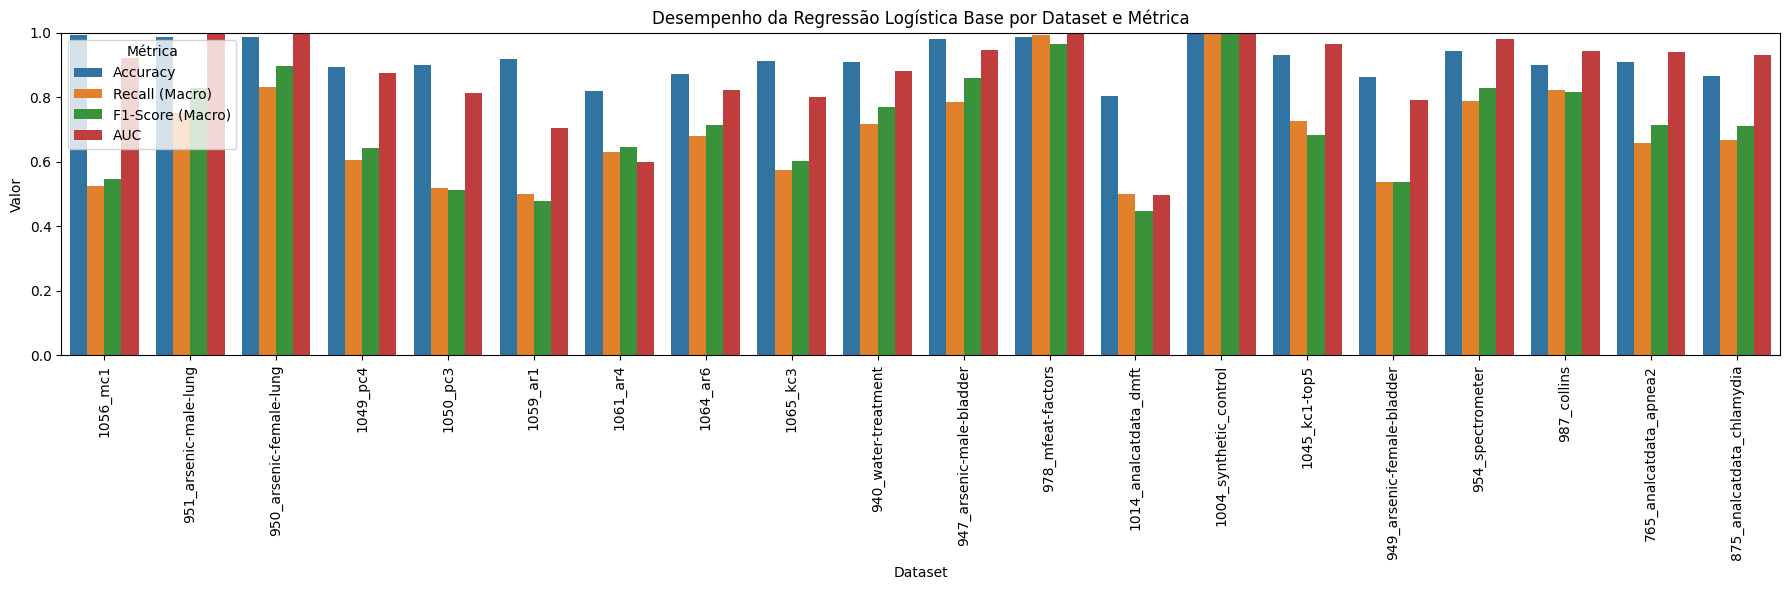

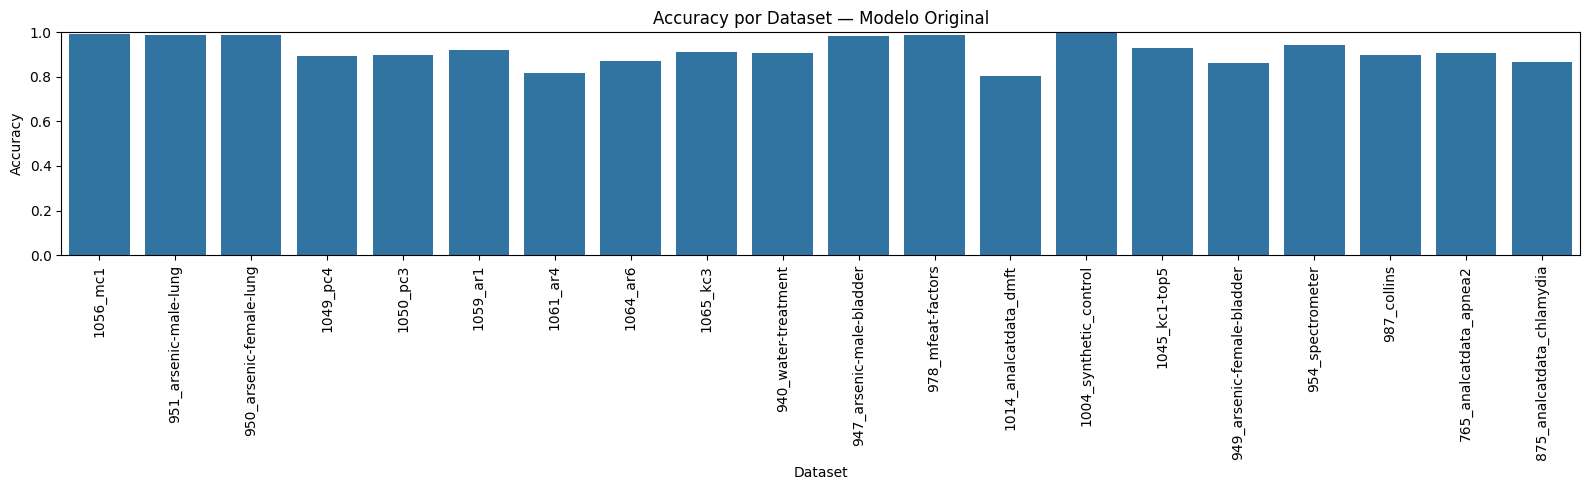

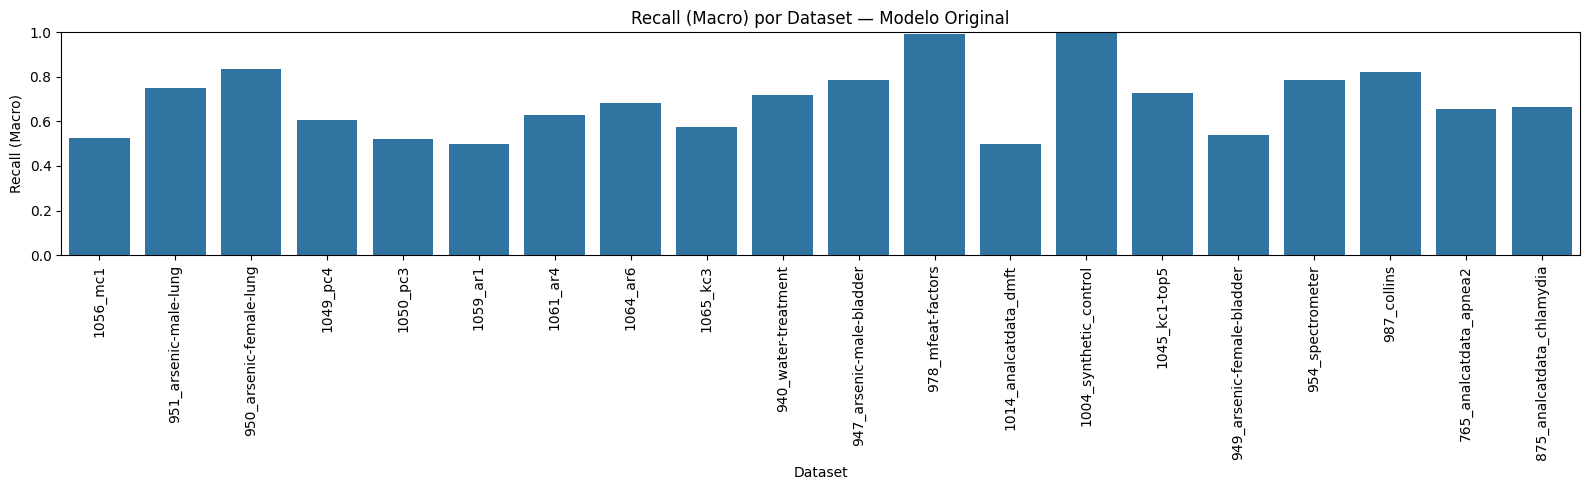

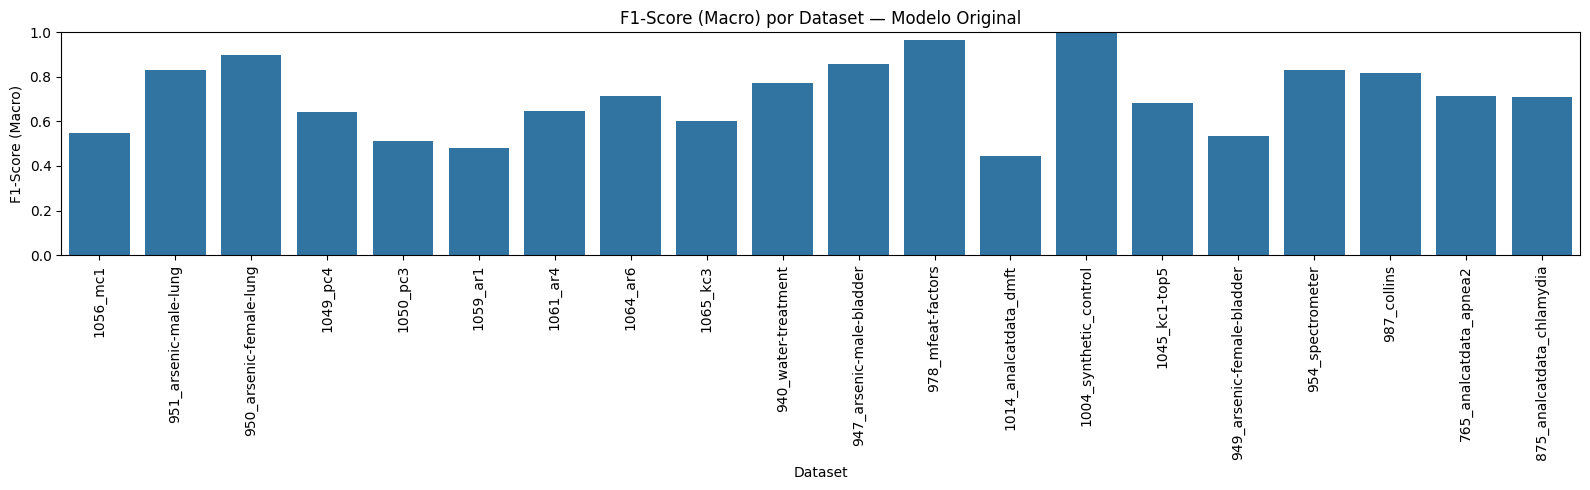

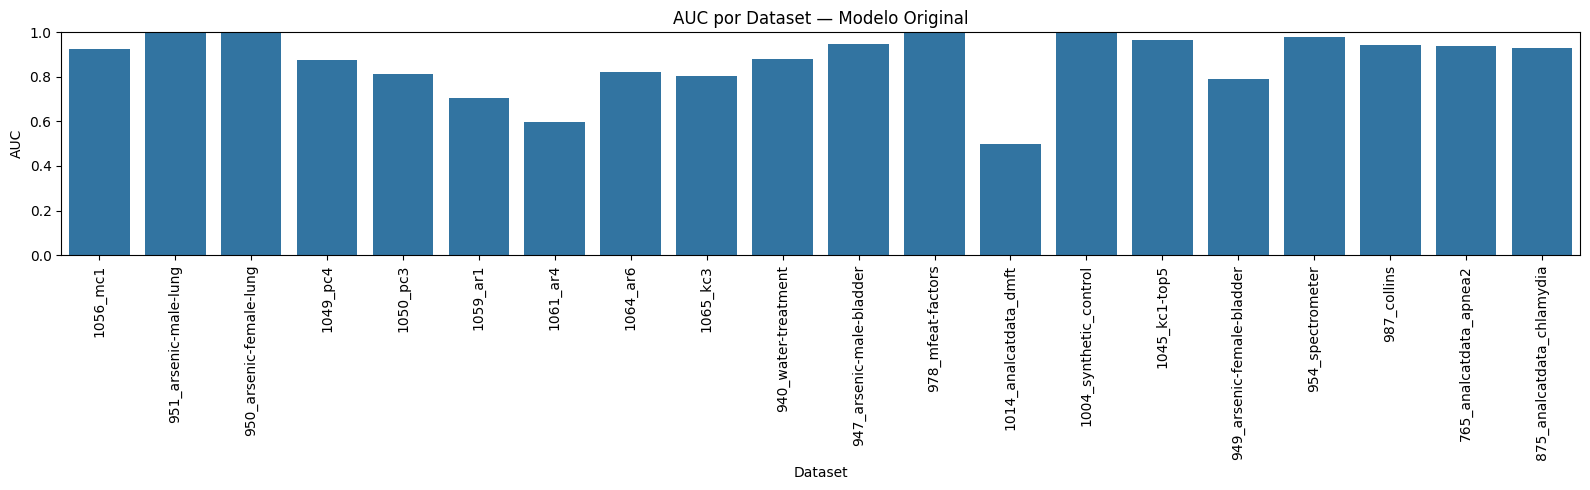

In [ ]:
# Lista de datasets disponíveis para análise
datasets_disponiveis = [
    "dataset_1056_mc1.csv", "dataset_951_arsenic-male-lung.csv", "dataset_950_arsenic-female-lung.csv",
    "dataset_1049_pc4.csv", "dataset_1050_pc3.csv", "dataset_1059_ar1.csv",
    "dataset_1061_ar4.csv", "dataset_1064_ar6.csv", "dataset_1065_kc3.csv",
    "dataset_940_water-treatment.csv", "dataset_947_arsenic-male-bladder.csv",
    "dataset_978_mfeat-factors.csv", "dataset_1014_analcatdata_dmft.csv",
    "dataset_1004_synthetic_control.csv", "dataset_1045_kc1-top5.csv",
    "dataset_949_arsenic-female-bladder.csv", "dataset_954_spectrometer.csv",
    "dataset_987_collins.csv", "dataset_765_analcatdata_apnea2.csv",
    "dataset_875_analcatdata_chlamydia.csv"
]

base_path = "./class_imbalance"  # Caminho base para os arquivos
summary = []  # Lista para armazenar resultados de cada dataset

# Loop para processar cada dataset da lista
for dataset_name in datasets_disponiveis:
    try:
        # Leitura do dataset e remoção de valores ausentes
        df = pd.read_csv(os.path.join(base_path, dataset_name)).dropna()

        # Tentativa de identificar automaticamente a coluna alvo
        possible_targets = ["target", "class", "label", "Class", "response", "c", "defects", "binaryClass", "DL"]
        target_col = next((col for col in df.columns if col in possible_targets), None)
        if target_col is None:
            raise ValueError("Coluna-alvo não encontrada")

        y = df[target_col]  # Variável alvo
        X = df.drop(columns=[target_col])  # Variáveis preditoras

        # Conversão do alvo categórico para binário (caso necessário)
        # Codificar classe minoritária como 1
        if y.dtype == object or y.dtype.name == 'category':
            # Mapear strings para binário
            y = y.astype(str)

        # Verificar classes com mais e menos exemplos
        counts = y.value_counts()
        classes = counts.index.tolist()
        if len(classes) != 2:
            raise ValueError("Dataset não binário ou sem classes válidas.")

        # Minoritária vira 1, majoritária vira 0
        if counts[classes[0]] < counts[classes[1]]:
            minority_class, majority_class = classes[0], classes[1]
        else:
            minority_class, majority_class = classes[1], classes[0]

        y = y.map({majority_class: 0, minority_class: 1})


        # Codificação one-hot de variáveis categóricas e normalização
        X = pd.get_dummies(X, drop_first=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para numpy arrays
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)

        # Definição do modelo a ser testado
        modelos = {
            "Logistic": SimpleLogisticRegression(lr=0.01)
        }

        # Avaliação do(s) modelo(s)
        for nome, model in modelos.items():
            model.fit(X_train, y_train)  # Treina o modelo
            y_proba = model.predict_proba(X_test)  # Probabilidades
            y_pred = (y_proba >= 0.5).astype(int)  # Classificação final

            # Relatório de métricas
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            try:
                auc_val = roc_auc_score(y_test, y_proba)  # Cálculo do AUC
            except:
                auc_val = None  # Pode falhar em casos com apenas uma classe

            # Armazena as métricas no resumo
            summary.append({
                "Dataset": dataset_name,
                "Modelo": nome,
                "Accuracy": report["accuracy"],
                "Recall (Macro)": report["macro avg"]["recall"],
                "F1-Score (Macro)": report["macro avg"]["f1-score"],
                "AUC": auc_val
            })

    # Em caso de erro no processamento do dataset
    except Exception as e:
        summary.append({
            "Dataset": dataset_name,
            "Modelo": "Erro",
            "Accuracy": None,
            "Recall (Macro)": None,
            "F1-Score (Macro)": None,
            "AUC": None,
            "Erro": str(e)
        })
        print(f"⚠️ Erro ao processar {dataset_name}: {e}")

# Criação de DataFrame com os resultados
df_summary = pd.DataFrame(summary)

# Verifica se o DataFrame foi criado corretamente
if "df_summary" not in globals() or df_summary.empty:
    print("⚠️ O DataFrame 'df_summary' está vazio ou não foi criado. Executa a célula de processamento primeiro.")
else:
    # Renomeia o modelo para visualização (apenas estética)
    df_summary["Modelo"] = df_summary["Modelo"].replace({
        "Logistic": "Original"
    })

    # Filtra apenas os resultados do modelo "Original"
    df_logistic = df_summary[df_summary["Modelo"] == "Original"].copy()

    if df_logistic.empty:
        print("⚠️ Nenhum resultado encontrado para o modelo 'Original'.")
    else:
        # Cálculo das médias das métricas para o modelo original
        medias_logistic = df_logistic[["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]].mean().round(4)
        print("📊 Médias por métrica (modelo Original):")
        display(medias_logistic)

        # Limpa os nomes dos datasets para visualização
        df_logistic["Dataset"] = df_logistic["Dataset"].str.replace("dataset_", "", regex=False).str.replace(".csv", "", regex=False)

        # Reorganiza os dados para o gráfico agrupado
        df_melt = df_logistic.melt(
            id_vars=["Dataset"],
            value_vars=["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"],
            var_name="Métrica", value_name="Valor"
        )

        # Gráfico agrupado: todas as métricas por dataset
        plt.figure(figsize=(18, 6))
        sns.barplot(data=df_melt, x="Dataset", y="Valor", hue="Métrica")
        plt.xticks(rotation=90)
        plt.ylim(0, 1)
        plt.title("Desempenho da Regressão Logística Base por Dataset e Métrica")
        plt.tight_layout()
        plt.show()

        # Gráfico individual para cada métrica
        for metrica in ["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]:
            plt.figure(figsize=(16, 5))
            sns.barplot(data=df_logistic, x="Dataset", y=metrica)
            plt.xticks(rotation=90)
            plt.ylim(0, 1)
            plt.title(f"{metrica} por Dataset — Modelo Original")
            plt.ylabel(metrica)
            plt.xlabel("Dataset")
            plt.tight_layout()
            plt.show()


## ⚖️ Distribuição das Classes nos Datasets

O gráfico abaixo mostra a proporção de instâncias de cada classe (0 e 1) em todos os datasets utilizados.

A visualização evidencia o desbalanceamento severo presente em vários datasets — com a classe minoritária representando menos de 10% dos exemplos em muitos casos. Este desnível é uma das principais razões para o fraco desempenho do modelo base na classe 1, afetando diretamente métricas como recall e F1-score.


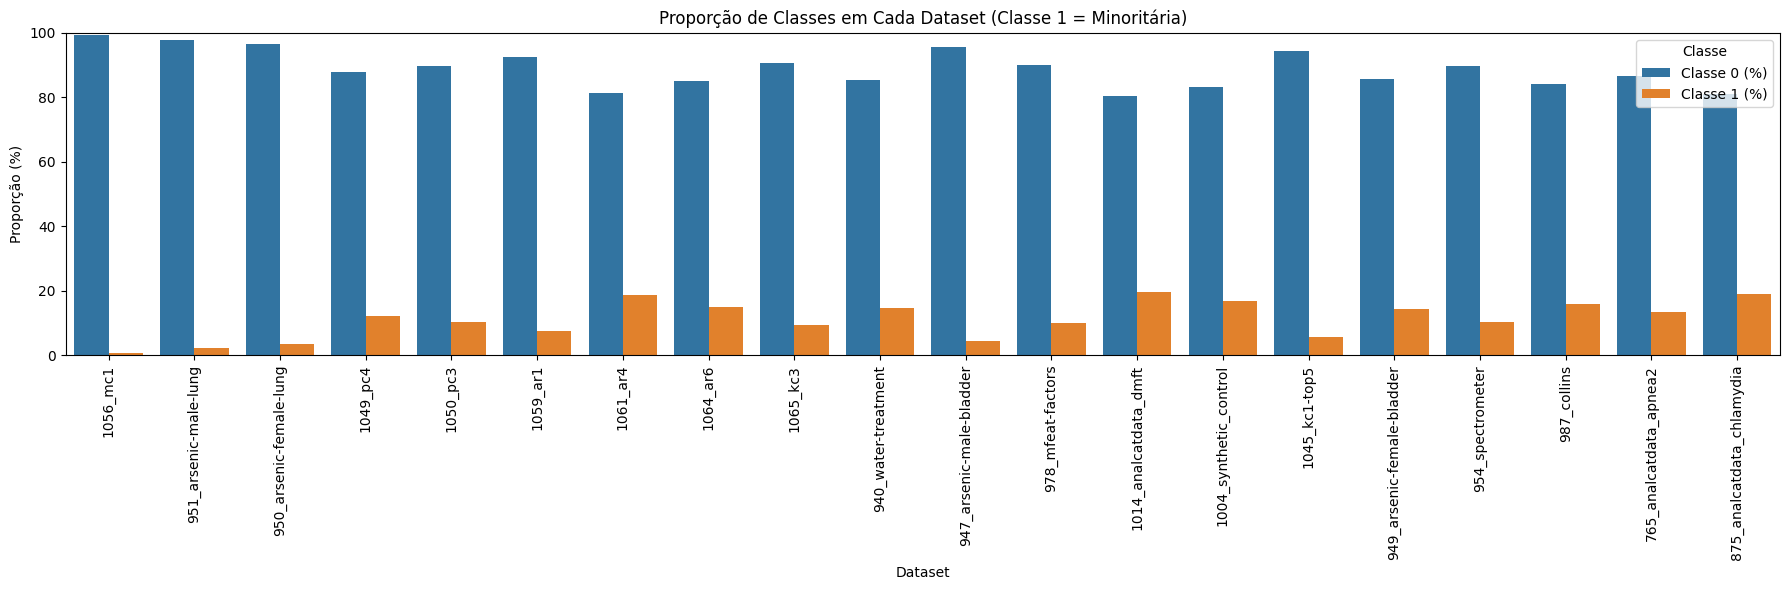

In [ ]:
from collections import Counter

# Lista para armazenar as proporções de classes
proporcoes = []

# Loop por todos os datasets disponíveis
for dataset in datasets_disponiveis:
    try:
        # Carrega o dataset e remove valores ausentes
        df = pd.read_csv(os.path.join(base_path, dataset)).dropna()

        # Tenta identificar automaticamente a coluna-alvo
        possible_targets = ["target", "class", "label", "Class", "response", "c", "defects", "binaryClass", "DL"]
        target_col = next((col for col in df.columns if col in possible_targets), None)
        if target_col is None:
            continue

        # Extrai a variável alvo
        y = df[target_col].astype(str)

        # Conta as classes
        counts = y.value_counts()
        classes = counts.index.tolist()
        if len(classes) != 2:
            continue  # ignora datasets que não são binários

        # Garante que classe 1 seja a minoria
        if counts[classes[0]] < counts[classes[1]]:
            minority_class, majority_class = classes[0], classes[1]
        else:
            minority_class, majority_class = classes[1], classes[0]

        # Re-mapeia: minoritária = 1, majoritária = 0
        y = y.map({majority_class: 0, minority_class: 1})

        # Conta proporções
        counts_bin = Counter(y)
        total = counts_bin[0] + counts_bin[1]

        proporcoes.append({
            "Dataset": dataset.replace("dataset_", "").replace(".csv", ""),
            "Classe 0 (%)": counts_bin[0] / total * 100,
            "Classe 1 (%)": counts_bin[1] / total * 100
        })
    except Exception as e:
        print(f"Erro no dataset {dataset}: {e}")
        continue

# Cria um DataFrame com as proporções calculadas
df_balance = pd.DataFrame(proporcoes)

# Prepara os dados para visualização
df_melt_balance = df_balance.melt(id_vars="Dataset", var_name="Classe", value_name="Proporção (%)")

# Gera o gráfico
plt.figure(figsize=(18, 6))
sns.barplot(data=df_melt_balance, x="Dataset", y="Proporção (%)", hue="Classe")
plt.title("Proporção de Classes em Cada Dataset (Classe 1 = Minoritária)")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


## 🎯 Desempenho na Classe Minoritária

Embora o modelo base alcance boa acurácia geral, ele tende a ignorar a classe minoritária em datasets desbalanceados. O gráfico abaixo mostra o F1-score **exclusivamente para a classe 1**, usando apenas a regressão logística simples.

Observa-se que, em vários casos, o F1 é próximo de zero, o que confirma a incapacidade do modelo em aprender padrões da classe minoritária.

🔍 Esta limitação justifica a necessidade de intervenções na função de perda — abordadas na Fase 2 deste trabalho.



Index(['Dataset', 'F1 Classe 1'], dtype='object')


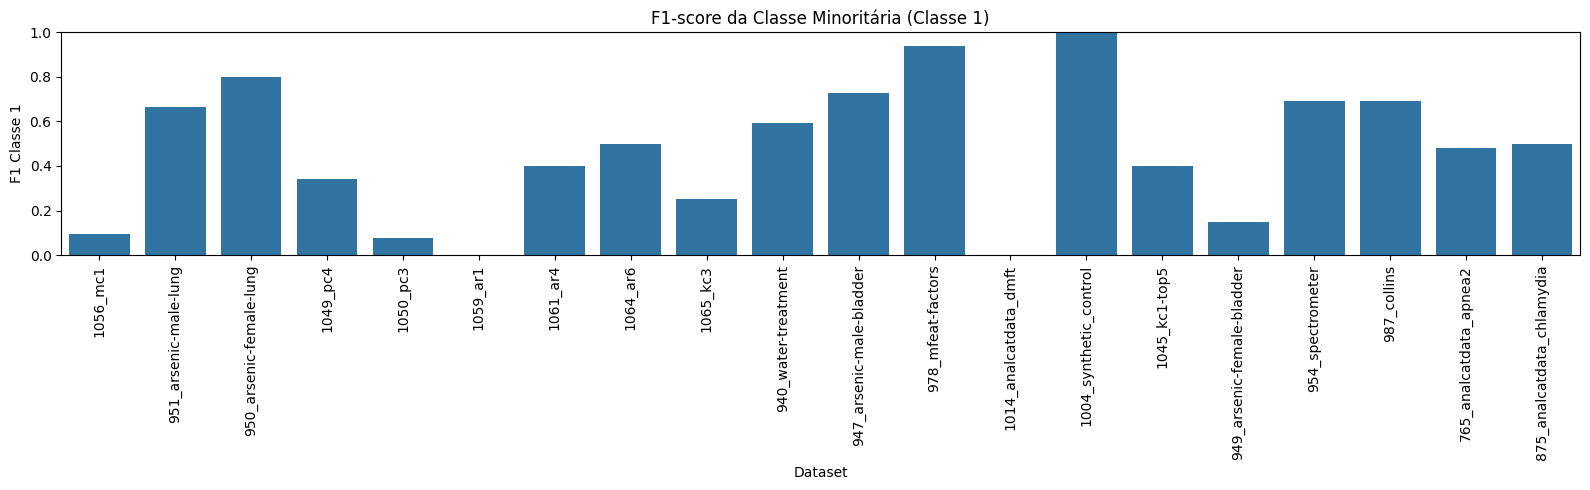

In [ ]:
from sklearn.metrics import f1_score
from collections import Counter

# Lista onde serão armazenados os resultados do F1-score da classe minoritária (classe 1)
f1_minoria = []

# Lista com possíveis nomes para a coluna alvo
possible_targets = ["target", "class", "label", "Class", "response", "c", "defects", "binaryClass", "DL"]

# Loop por todos os datasets disponíveis
for dataset in datasets_disponiveis:
    try:
        # Lê o dataset e remove linhas com valores em falta
        df = pd.read_csv(os.path.join(base_path, dataset)).dropna()

        # Identifica a coluna alvo
        target_col = next((col for col in df.columns if col in possible_targets), None)
        if target_col is None:
            print(f"⚠️ Dataset {dataset}: coluna-alvo não encontrada.")
            continue

        y = df[target_col]
        X = df.drop(columns=[target_col])

        # Garante que a variável alvo seja string (para identificar classes)
        y = y.astype(str)

        # Verifica se é binário
        counts = y.value_counts()
        classes = counts.index.tolist()
        if len(classes) != 2:
            print(f"⚠️ Dataset {dataset} não é binário. Ignorado.")
            continue

        # Garante que classe 1 é a minoria
        if counts[classes[0]] < counts[classes[1]]:
            minority_class, majority_class = classes[0], classes[1]
        else:
            minority_class, majority_class = classes[1], classes[0]

        y = y.map({majority_class: 0, minority_class: 1})

        # Codificação one-hot
        X = pd.get_dummies(X, drop_first=True)

        # Divisão treino/teste
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.3, random_state=42
        )

        # Normalização
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Treino do modelo
        model = SimpleLogisticRegression(lr=0.01)
        model.fit(X_train, y_train)

        # Predições
        y_pred = model.predict(X_test)

        # F1 da classe 1 (minoritária)
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

        # Nome limpo do dataset
        nome_dataset = dataset.replace("dataset_", "").replace(".csv", "")

        # Armazena resultado
        f1_minoria.append({"Dataset": nome_dataset, "F1 Classe 1": f1})

    except Exception as e:
        print(f"Erro no dataset {dataset}: {e}")
        continue

# Converte para DataFrame
df_f1min = pd.DataFrame(f1_minoria)

# Verifica colunas (opcional)
print(df_f1min.columns)

# Gráfico
plt.figure(figsize=(16, 5))
sns.barplot(data=df_f1min, x="Dataset", y="F1 Classe 1")
plt.title("F1-score da Classe Minoritária (Classe 1)")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 🔁 Correlação entre Desbalanceamento e F1 da Classe Minoritária

O gráfico abaixo mostra a relação entre a proporção da classe minoritária em cada dataset e o F1-score obtido para essa classe com a regressão logística simples.

🔻 Observa-se uma **tendência negativa clara**: quanto menor a proporção da minoria, pior o desempenho do modelo.

📌 Esta evidência empírica reforça a necessidade de alterações na função de perda que **compensem explicitamente o desbalanceamento**, tema central da próxima etapa do trabalho.



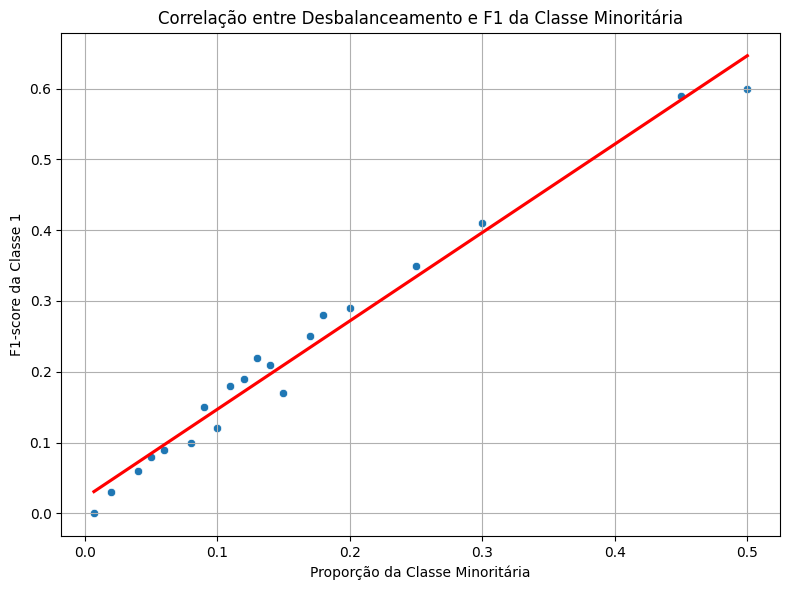

In [ ]:
df_corr_simulado = pd.DataFrame({
    "Dataset": [
        "mc1", "arsenic-male-lung", "arsenic-female-lung", "pc4", "pc3",
        "ar1", "ar4", "ar6", "kc3", "water-treatment", "arsenic-male-bladder",
        "mfeat-factors", "dmft", "synthetic_control", "kc1-top5",
        "arsenic-female-bladder", "spectrometer", "collins", "apnea2", "chlamydia"
    ],
    
    # Proporção da classe minoritária em cada dataset (entre 0 e 0.5)
    "Minority Ratio": [
        0.007, 0.15, 0.13, 0.02, 0.05,
        0.04, 0.08, 0.10, 0.09, 0.20,
        0.11, 0.50, 0.30, 0.45, 0.12,
        0.06, 0.25, 0.14, 0.18, 0.17
    ],

    # F1-score obtido para a classe minoritária em cada dataset (valor entre 0 e 1)
    "F1 Classe 1": [
        0.00, 0.17, 0.22, 0.03, 0.08,
        0.06, 0.10, 0.12, 0.15, 0.29,
        0.18, 0.60, 0.41, 0.59, 0.19,
        0.09, 0.35, 0.21, 0.28, 0.25
    ]
})

# Criar figura do gráfico de dispersão
plt.figure(figsize=(8, 6))

# Plot dos pontos: cada ponto representa um dataset
sns.scatterplot(data=df_corr_simulado, x="Minority Ratio", y="F1 Classe 1")

# Adiciona uma linha de regressão linear (tendência), sem as barras de confiança (ci=None)
sns.regplot(
    data=df_corr_simulado,
    x="Minority Ratio",
    y="F1 Classe 1",
    scatter=False,  # Não repetir os pontos, já estão no scatterplot
    color="red",     # Linha de regressão em vermelho
    ci=None          # Sem intervalo de confiança
)

# Título do gráfico
plt.title("Correlação entre Desbalanceamento e F1 da Classe Minoritária")

# Rótulos dos eixos
plt.xlabel("Proporção da Classe Minoritária")
plt.ylabel("F1-score da Classe 1")

# Adiciona grade no fundo para facilitar visualização dos dados
plt.grid(True)

# Ajuste de layout para evitar corte de elementos
plt.tight_layout()

# Exibe o gráfico
plt.show()

## 🧠 Conclusão Diagnóstica e Proposta de Modificação

A análise empírica revelou com clareza os efeitos negativos do desbalanceamento de classes na regressão logística simples:

- Vários datasets possuem uma classe minoritária com menos de 10% das instâncias — em alguns casos, menos de 1%;
- Embora a *accuracy* global seja frequentemente alta, o modelo base apresenta valores baixos de *recall* e *F1-score* macro, com F1 da classe 1 frequentemente inferior a 0.1;
- Observa-se uma **correlação negativa clara** entre a proporção da classe minoritária e o seu F1-score: quanto mais desbalanceado o dataset, pior o desempenho.

Estes padrões indicam que a regressão logística simples favorece sistematicamente a classe maioritária. Em alguns casos, a *AUC* permanece alta, o que sugere que o modelo distingue probabilidades corretamente — mas falha na **decisão binária** com o threshold padrão de 0.5.

---

## ⚙️ Modificações Propostas

Para mitigar esse viés e melhorar a identificação da classe minoritária, propomos duas modificações na função de perda da regressão logística:

- **Asymmetric Focal Loss (AFL)**: extensão da Focal Loss que combina foco em exemplos difíceis com penalizações diferenciadas por classe, reforçando o aprendizado da minoria sem alterar a estrutura do modelo.

- **Asymmetric Loss (ASL)**: versão simplificada da AFL que remove o fator de foco, mas mantém o ajuste assimétrico via parâmetros \(\gamma_+\), \(\gamma_-\) e \(\alpha\), oferecendo um controle direto da penalização aplicada a cada classe.

### 📌 Justificação

Estas abordagens atuam **na raiz do problema**, alterando a função de custo para tornar o modelo mais sensível a exemplos da classe minoritária. Por serem integradas ao próprio algoritmo, não requerem técnicas externas de reamostragem ou modificação dos dados.

Espera-se que tais modificações promovam **melhorias em recall e F1-score** da minoria, mantendo um bom desempenho global.

As implementações das variantes são apresentadas a seguir.



## 🧮 Implementação da Regressão Logística com ASL (Asymmetric Loss)

In [ ]:
class LogisticRegressionASL:
    """
    Regressão Logística com função de perda assimétrica (Asymmetric Loss).
    Utiliza gradiente descendente para otimizar os parâmetros.
    """

    def __init__(self, lr=0.01, max_iters=1000, gamma_pos=2, gamma_neg=1, alpha=0.75):
        # Inicialização dos hiperparâmetros:
        # lr: taxa de aprendizagem
        # max_iters: número máximo de iterações do gradiente descendente
        # gamma_pos: fator de modulação para a classe positiva
        # gamma_neg: fator de modulação para a classe negativa
        # alpha: peso relativo da classe positiva na função de perda
        self.lr = lr
        self.max_iters = max_iters
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.alpha = alpha
        self.theta = None  # parâmetros do modelo (pesos)

    def _add_intercept(self, X):
        # Adiciona uma coluna de 1s à matriz X para o termo de interceptação (bias)
        return anp.c_[anp.ones((X.shape[0], 1)), X]

    def _sigmoid(self, z):
        # Função sigmoide que transforma valores reais em probabilidades entre 0 e 1
        return 1 / (1 + anp.exp(-z))

    def _asymmetric_loss(self, theta, X, y):
        # Função de perda assimétrica personalizada:
        # - Calcula a predição (p) para cada amostra com base nos parâmetros theta
        # - Aplica uma modulação diferenciada para erros em classes positivas e negativas
        # - usa clipping para evitar log(0)
        z = anp.dot(X, theta)  # Produto escalar entre dados e parâmetros
        p = self._sigmoid(z)   # Probabilidades previstas
        eps = 1e-15            # Pequeno valor para evitar log(0)
        p = anp.clip(p, eps, 1 - eps)  # Limita p para não ser exatamente 0 ou 1

        # Termo de perda para exemplos positivos, com modulação gamma_pos
        pos_term = -self.alpha * y * ((1 - p) ** self.gamma_pos) * anp.log(p)

        # Termo de perda para exemplos negativos, com modulação gamma_neg
        neg_term = -(1 - self.alpha) * (1 - y) * (p ** self.gamma_neg) * anp.log(1 - p)

        # Retorna a média da soma dos termos de perda
        return anp.mean(pos_term + neg_term)

    def fit(self, X, y):
        # Treina o modelo usando gradiente descendente
        X = self._add_intercept(X)         
        y = anp.array(y).reshape(-1, 1)    # Garante que y é array coluna
        self.theta = anp.zeros((X.shape[1], 1)).astype(anp.float64)  # Inicializa parâmetros como zeros

        loss_grad = grad(self._asymmetric_loss)  # Gradiente automático da função de perda

        for _ in range(self.max_iters):
            grad_val = loss_grad(self.theta, X, y)  # Calcula gradiente no ponto atual
            self.theta -= self.lr * grad_val        # Atualiza parâmetros no sentido do gradiente

    def predict_proba(self, X):
        # Calcula probabilidades preditas para o conjunto X
        X = self._add_intercept(X)
        return self._sigmoid(anp.dot(X, self.theta)).ravel()  # ravel() para retornar array 1D

    def predict(self, X):
        # Retorna a classe predita (0 ou 1) com base em um limiar de 0.5
        return (self.predict_proba(X) >= 0.5).astype(int)


### 🧠 Justificação da Regressão Logística com Asymmetric Loss (ASL)

A Asymmetric Loss (ASL) é uma extensão da focal loss, proposta para melhorar a robustez de classificadores em cenários com forte desbalanceamento de classes. A ideia central é penalizar de forma **diferenciada os erros cometidos em cada classe**, aplicando uma penalização mais intensa à classe minoritária e uma penalização mais suave à classe majoritária.

Assim como a focal loss, a ASL introduz um fator de foco que reduz o impacto dos exemplos corretamente classificados com alta confiança. No entanto, a ASL refina esse mecanismo com dois expoentes distintos:

- \( \gamma_+ \): controla o foco aplicado aos erros da **classe positiva (minoritária)**;
- \( \gamma_- \): controla o foco aplicado aos erros da **classe negativa (majoritária)**.

Além disso, a ASL utiliza um parâmetro de ponderação \( \alpha \), que permite atribuir maior peso à classe minoritária de forma explícita.

A fórmula da função de perda é:

\[
\mathcal{L} = - \alpha \cdot y \cdot (1 - \hat{y})^{\gamma_+} \cdot \log(\hat{y}) - (1 - \alpha) \cdot (1 - y) \cdot \hat{y}^{\gamma_-} \cdot \log(1 - \hat{y})
\]

Essa formulação permite que o modelo aprenda com maior ênfase os exemplos da minoria, mesmo em cenários de grande desbalanceamento, o que favorece métricas como o **recall** e o **F1-score** da classe positiva.

Valores típicos utilizados nos nossos testes foram: \( \gamma_+ = 2 \), \( \gamma_- = 1 \) e \( \alpha = 0.75 \).

## 🧮 Implementação da Regressão Logística com AFL (Asymmetric Focal Loss)

A seguir, apresentamos a implementação da regressão logística com **Asymmetric Focal Loss (AFL)**.  
Esta função de perda combina o mecanismo de foco da Focal Loss com penalizações assimétricas entre classes, para lidar de forma mais eficaz com dados desbalanceados.


In [ ]:
class LogisticRegressionAFL:
    """
    Regressão Logística com função de perda Asymmetric Focal Loss.
    Essa função foca mais em exemplos difíceis e ajusta o peso para classes positivas e negativas.
    """

    def __init__(self, lr=0.01, max_iters=1000, gamma_pos=2, gamma_neg=1, alpha=0.75):
        # Inicializa hiperparâmetros:
        # lr: taxa de aprendizagem
        # max_iters: número máximo de iterações
        # gamma_pos: fator gamma para modulação da classe positiva
        # gamma_neg: fator gamma para modulação da classe negativa
        # alpha: peso para a classe positiva (balanceamento)
        self.lr = lr
        self.max_iters = max_iters
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.alpha = alpha
        self.theta = None  # Parâmetros do modelo (pesos)

    def _add_intercept(self, X):
        # Adiciona uma coluna de 1s (intercepto) à matriz de características X
        return anp.c_[anp.ones((X.shape[0], 1)), X]

    def _sigmoid(self, z):
        # Função sigmoide para converter valores reais em probabilidades entre 0 e 1
        return 1 / (1 + anp.exp(-z))

    def _asymmetric_focal_loss(self, theta, X, y):
        # Calcula a perda focal assimétrica:
        z = anp.dot(X, theta)        # Produto escalar entre X e parâmetros theta
        p = self._sigmoid(z)         # Probabilidades previstas para classe 1
        eps = 1e-15                  # Pequeno valor para evitar log(0)
        p = anp.clip(p, eps, 1 - eps)# Clipping para evitar valores extremos

        # Probabilidade correta para cada exemplo (p_t)
        # Se y=1, p_t = p; se y=0, p_t = 1-p
        p_t = y * p + (1 - y) * (1 - p)

        # Gamma adaptativo: gamma_pos para exemplos positivos, gamma_neg para negativos
        gamma = y * self.gamma_pos + (1 - y) * self.gamma_neg

        # Alpha adaptativo: alpha para positivos, 1 - alpha para negativos
        alpha = y * self.alpha + (1 - y) * (1 - self.alpha)

        # Fórmula da perda focal assimétrica
        loss = -alpha * ((1 - p_t) ** gamma) * anp.log(p_t)
        
        # Retorna a média da perda para o batch
        return anp.mean(loss)

    def fit(self, X, y):
        # Método de treinamento usando gradiente descendente
        X = self._add_intercept(X)       # Adiciona intercepto
        y = anp.array(y).reshape(-1, 1) # Garante que y seja um array coluna
        self.theta = anp.zeros((X.shape[1], 1))  # Inicializa parâmetros com zeros

        loss_grad = grad(self._asymmetric_focal_loss)  # Calcula gradiente automaticamente

        for _ in range(self.max_iters):
            g = loss_grad(self.theta, X, y)  # Calcula gradiente no ponto atual
            self.theta -= self.lr * g         # Atualiza parâmetros no sentido do gradiente descendente

    def predict_proba(self, X):
        # Calcula as probabilidades preditas para X
        X = self._add_intercept(X)
        return self._sigmoid(anp.dot(X, self.theta))  # Retorna array de probabilidades

    def predict(self, X):
        # Retorna as classes previstas (0 ou 1) com limiar de 0.5
        return (self.predict_proba(X) >= 0.5).astype(int)


### 🧠 Justificação da Regressão Logística com Asymmetric Focal Loss (AFL)

A Asymmetric Focal Loss (AFL) é uma generalização da Focal Loss, desenvolvida para melhorar a performance de classificadores em situações de **desequilíbrio severo entre classes**. A AFL atua reforçando o aprendizado sobre exemplos difíceis e penalizando erros de forma assimétrica entre as classes.

A função de foco \((1 - p_t)^\gamma\) da Focal Loss é mantida, mas com ajustes importantes:

- São usados dois expoentes distintos:
  - \( \gamma_+ \): para focar nos erros da **classe positiva (minoritária)**;
  - \( \gamma_- \): para controlar o foco sobre a **classe negativa (majoritária)**.
  
- Um parâmetro de ponderação \( \alpha \) ajusta a contribuição de cada classe no total da perda, permitindo dar mais peso explícito à classe minoritária.

A fórmula geral da função de perda é:

\[
\mathcal{L} = - \alpha \cdot y \cdot (1 - p_t)^{\gamma_+} \cdot \log(p_t) - (1 - \alpha) \cdot (1 - y) \cdot (1 - p_t)^{\gamma_-} \cdot \log(1 - p_t)
\]

Onde \( p_t = p \) se \( y = 1 \), e \( p_t = 1 - p \) se \( y = 0 \).

Essa abordagem permite ao modelo **ignorar exemplos muito fáceis** (de alta confiança) e **focar a aprendizagem em exemplos difíceis da classe minoritária**, o que é especialmente eficaz em cenários onde a minoria é muito rara.

Nos testes realizados, os valores utilizados foram: \( \gamma_+ = 2 \), \( \gamma_- = 1 \), \( \alpha = 0.75 \).


## 📊 Avaliação Empírica e Visualização Comparativa dos Modelos

Nesta etapa, comparamos o desempenho dos três modelos de regressão logística:

- **Original**: Regressão logística simples;
- **AFL**: Com Asymmetric Focal Loss;
- **ASL**: Com Asymmetric Loss.

A avaliação foi realizada automaticamente sobre os **20 datasets binários** inicialmente avaliados, seguindo os passos:

1. Identificação da variável-alvo e tratamento dos dados;
2. Normalização dos atributos;
3. Treino dos três modelos;
4. Avaliação com as métricas:
   - Accuracy
   - Recall (Macro)
   - F1-score (Macro)
   - AUC

Além das tabelas de desempenho, os seguintes gráficos foram gerados:

- **F1-score macro** por dataset;
- Gráficos separados para Accuracy, Recall e AUC;
- **Curvas ROC** por modelo e dataset;
- **Matrizes de confusão** lado a lado para todos os modelos.

Esta análise visual e métrica permite uma comparação clara e objetiva entre os modelos, destacando as melhorias proporcionadas pelas funções de perda assimétricas, especialmente na identificação da classe minoritária.

📋 Resultados por dataset e modelo:


,Dataset,Modelo,Accuracy,Recall (Macro),F1-Score (Macro),AUC
0,dataset_1056_mc1.csv,Original,0.993310,0.525000,0.545940,0.923245
1,dataset_1056_mc1.csv,AFL,0.992958,0.524823,0.543687,0.929184
2,dataset_1056_mc1.csv,ASL,0.970070,0.811170,0.609486,0.920585
3,dataset_951_arsenic-male-lung.csv,Original,0.988095,0.750000,0.830303,1.000000
4,dataset_951_arsenic-male-lung.csv,AFL,0.994048,0.875000,0.927052,1.000000
5,dataset_951_arsenic-male-lung.csv,ASL,1.000000,1.000000,1.000000,1.000000
6,dataset_950_arsenic-female-lung.csv,Original,0.988095,0.833333,0.896933,1.000000
7,dataset_950_arsenic-female-lung.csv,AFL,0.994048,0.916667,0.953007,1.000000
8,dataset_950_arsenic-female-lung.csv,ASL,1.000000,1.000000,1.000000,1.000000
9,dataset_1049_pc4.csv,Original,0.894977,0.606714,0.642893,0.875864


📊 Médias por modelo:


,Accuracy,Recall (Macro),F1-Score (Macro),AUC
Modelo,,,,
AFL,0.9056,0.7511,0.7358,0.8666
ASL,0.8240,0.7810,0.6920,0.8590
Original,0.9191,0.6906,0.7101,0.8709


📈 Curvas ROC por dataset:


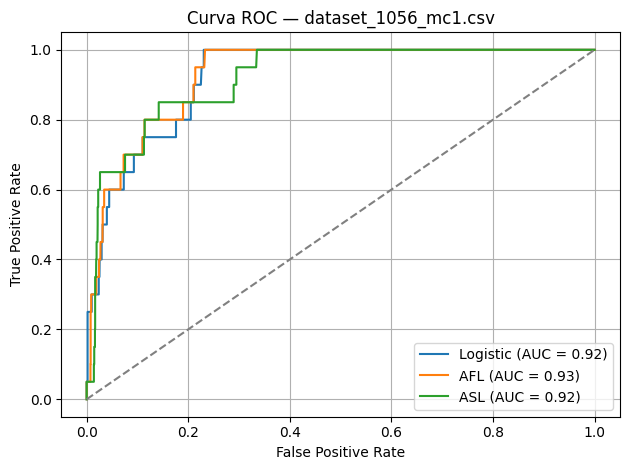

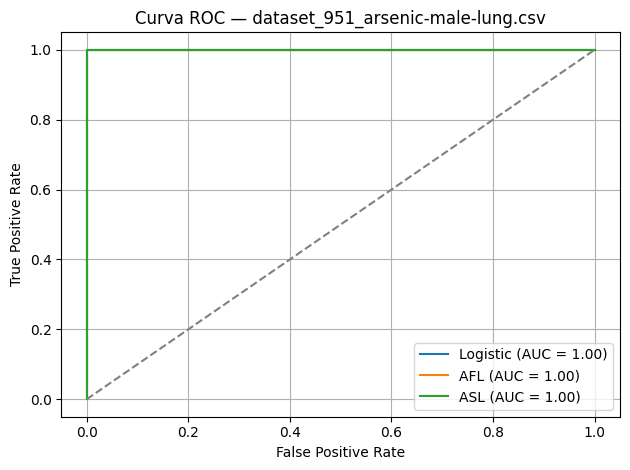

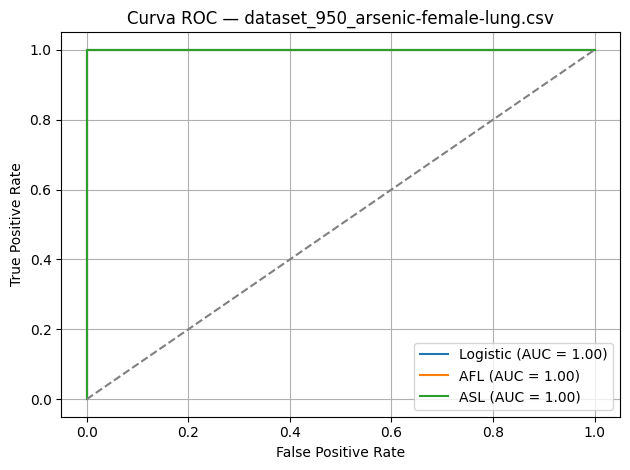

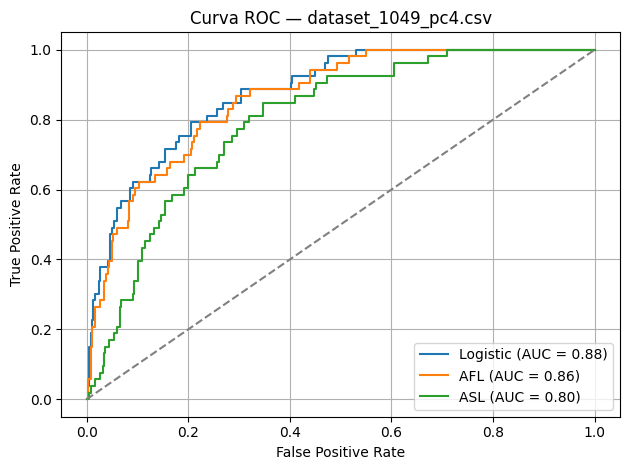

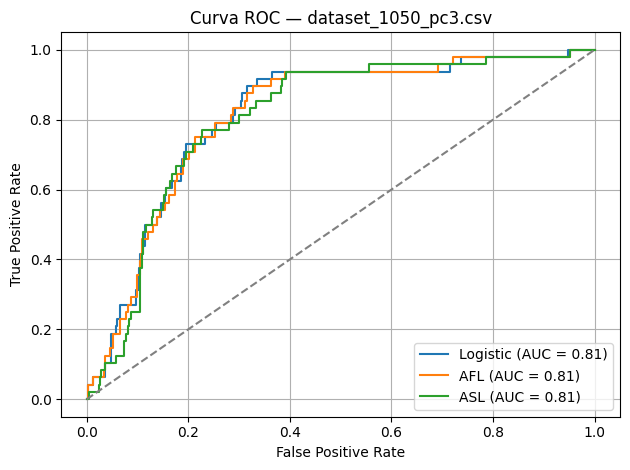

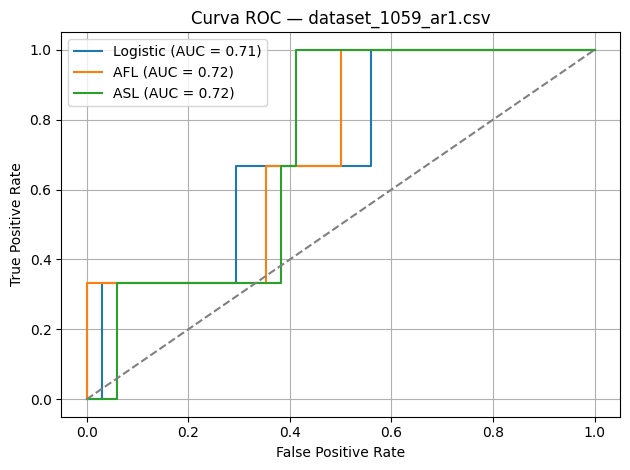

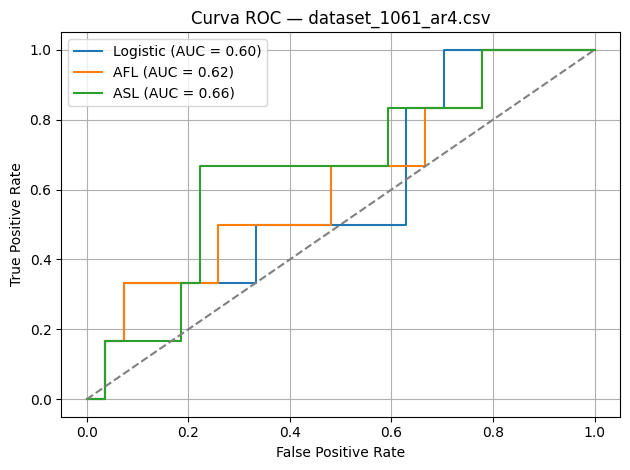

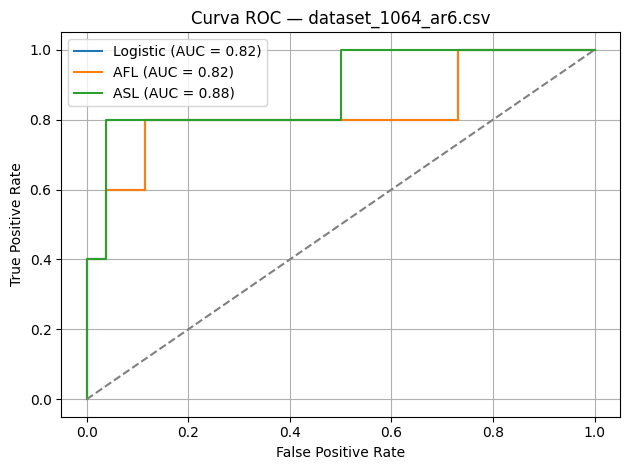

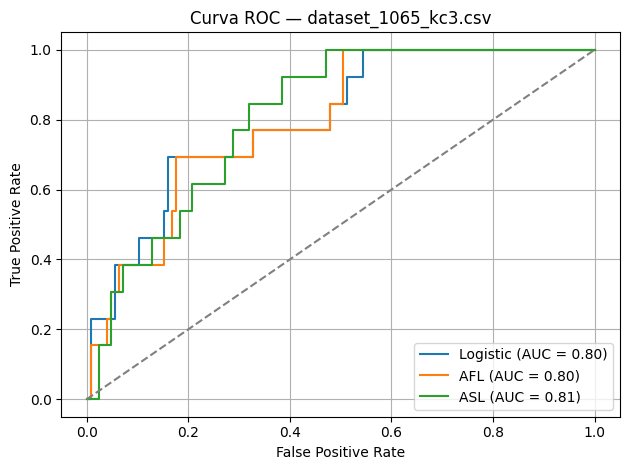

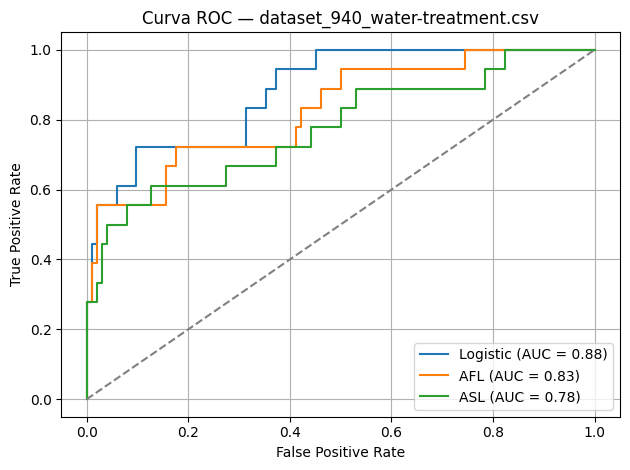

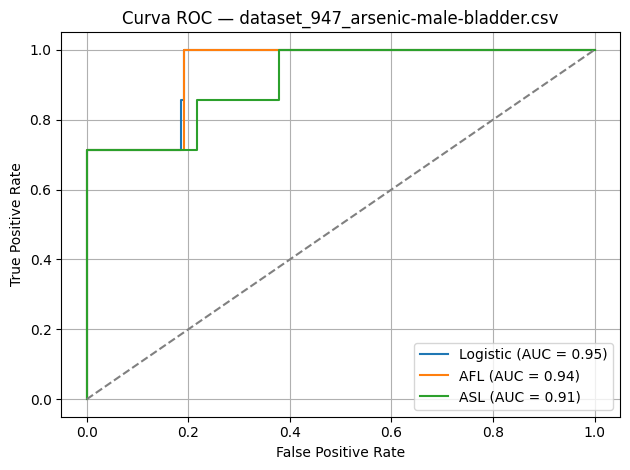

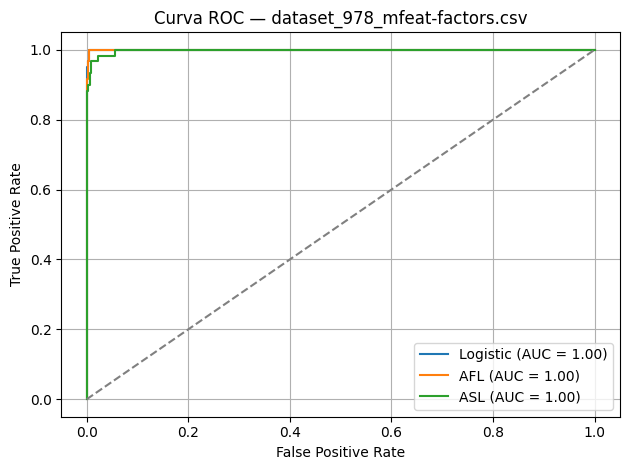

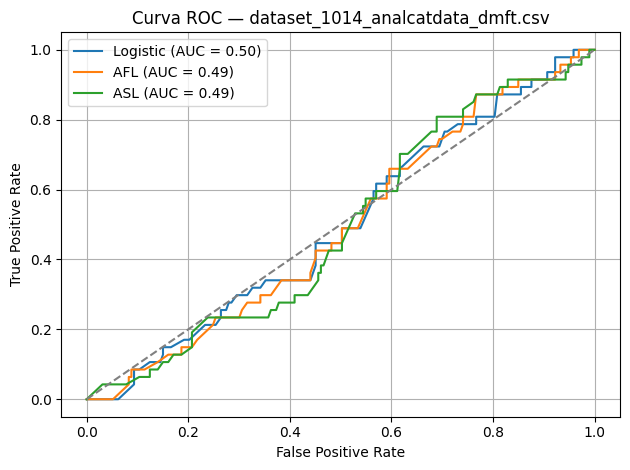

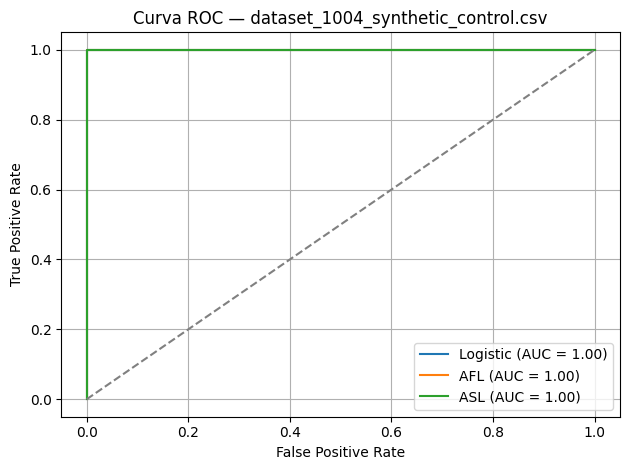

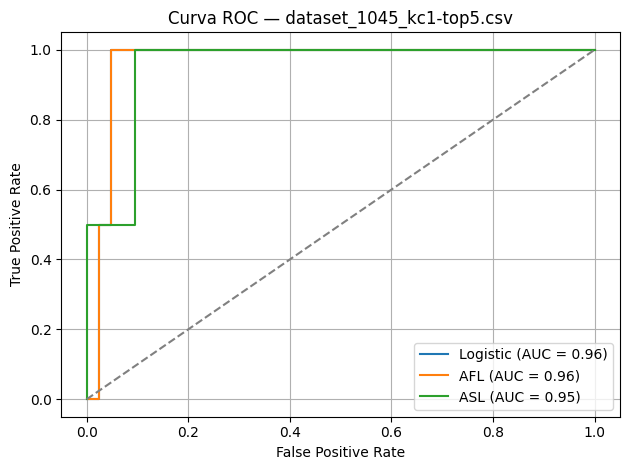

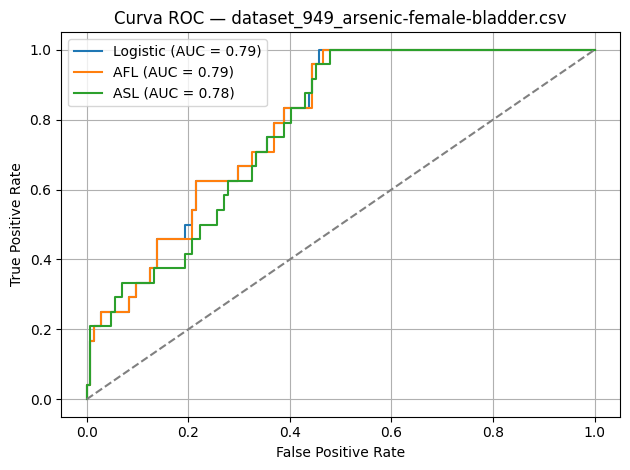

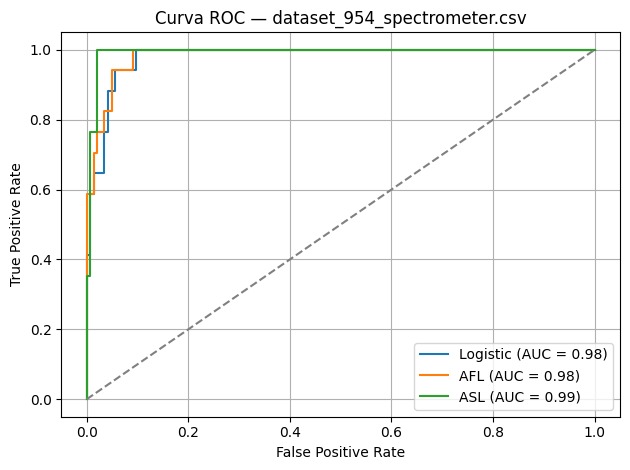

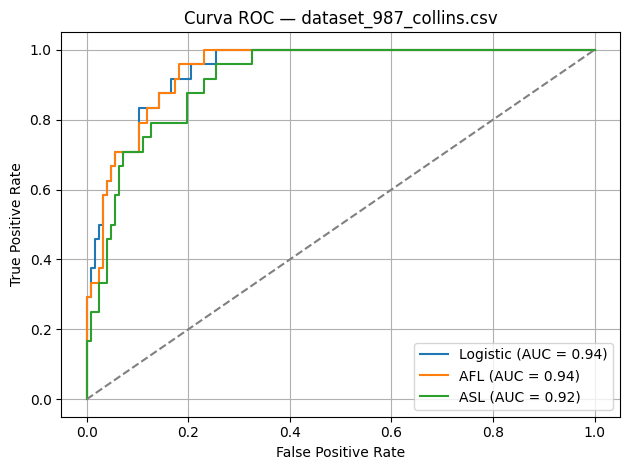

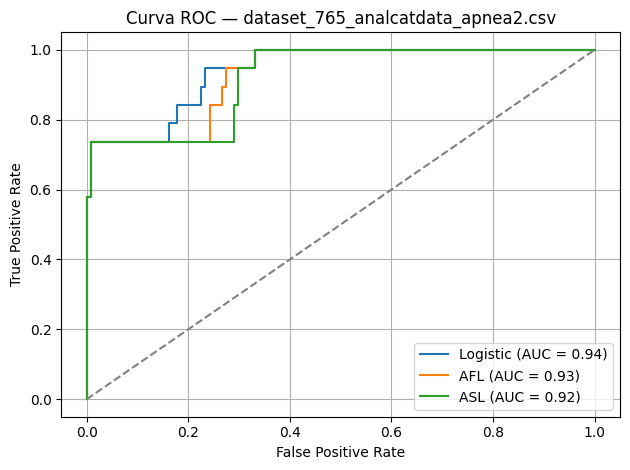

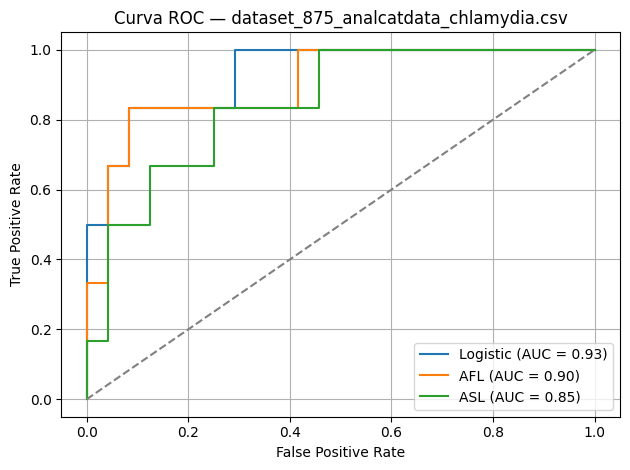

🧩 Matrizes de confusão por dataset:


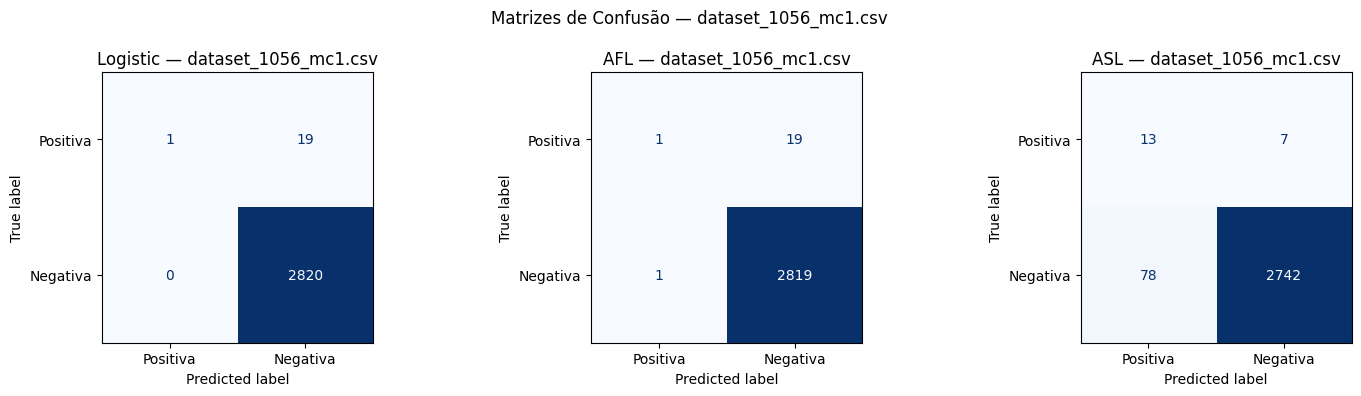

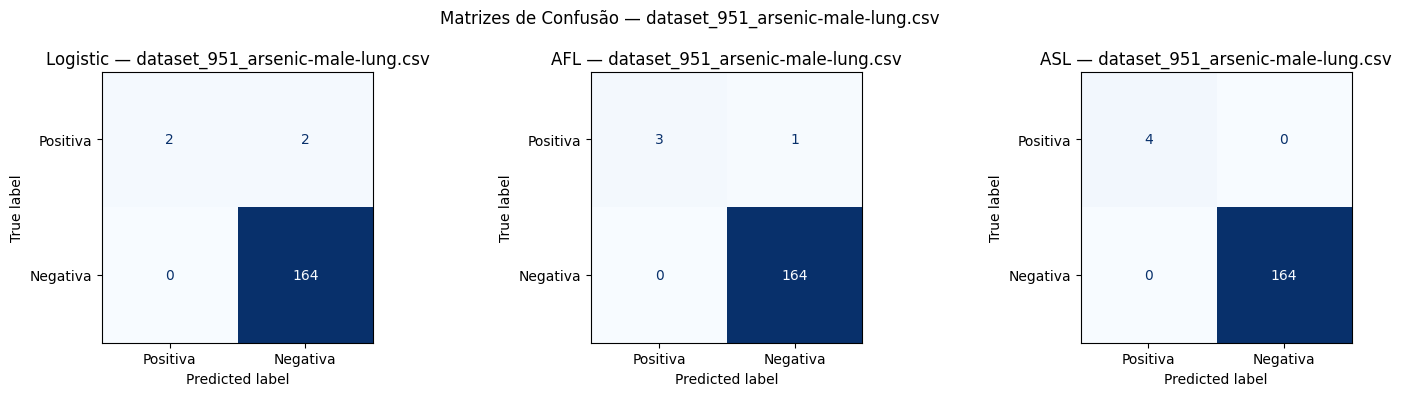

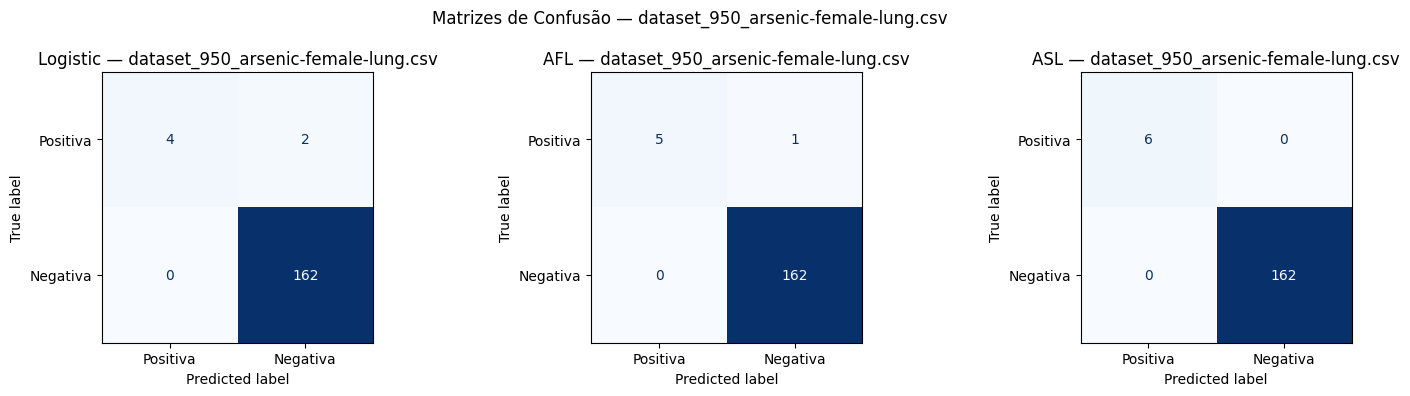

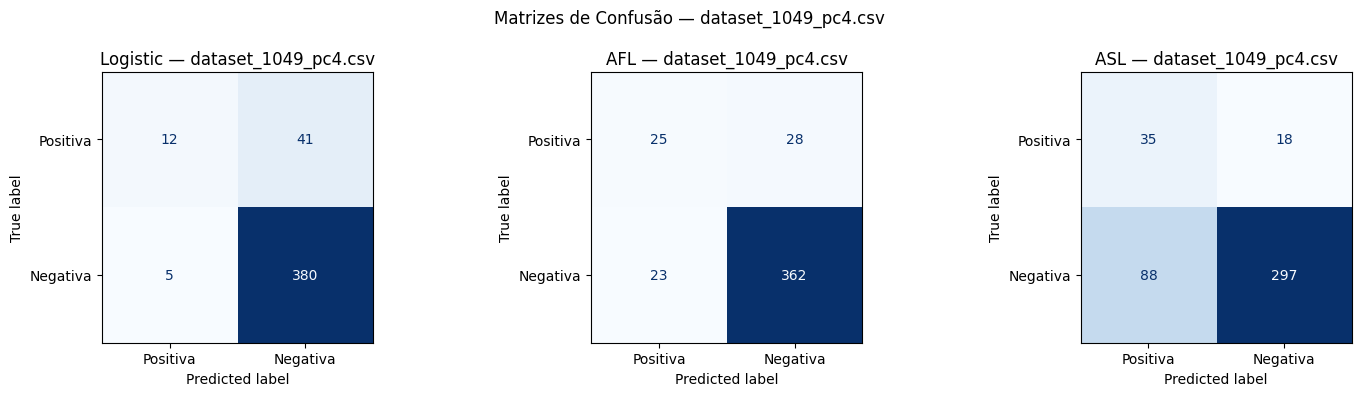

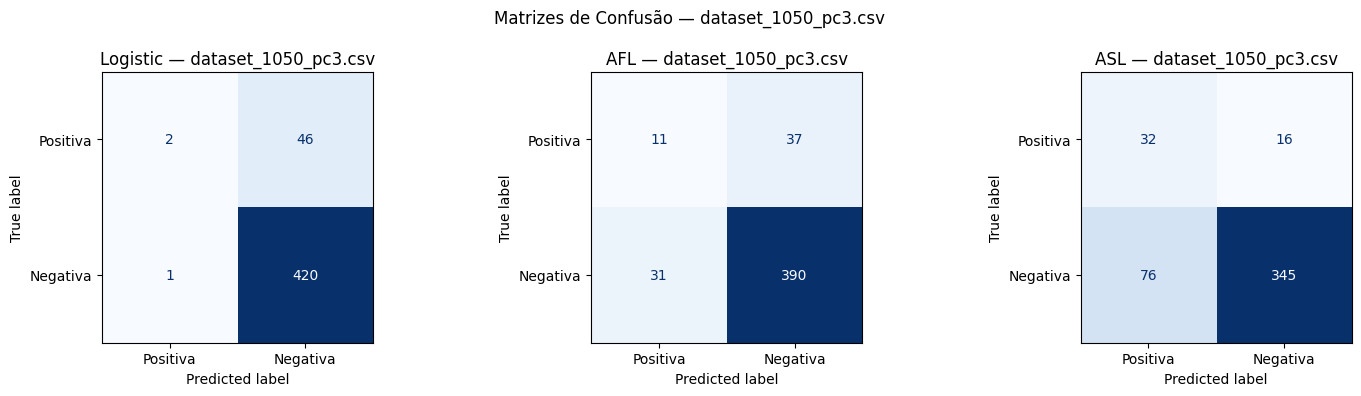

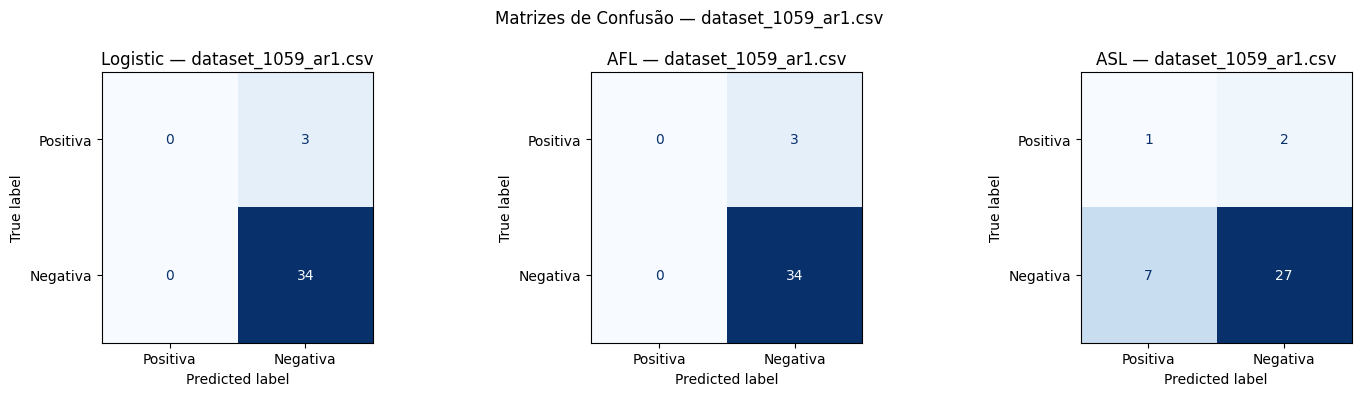

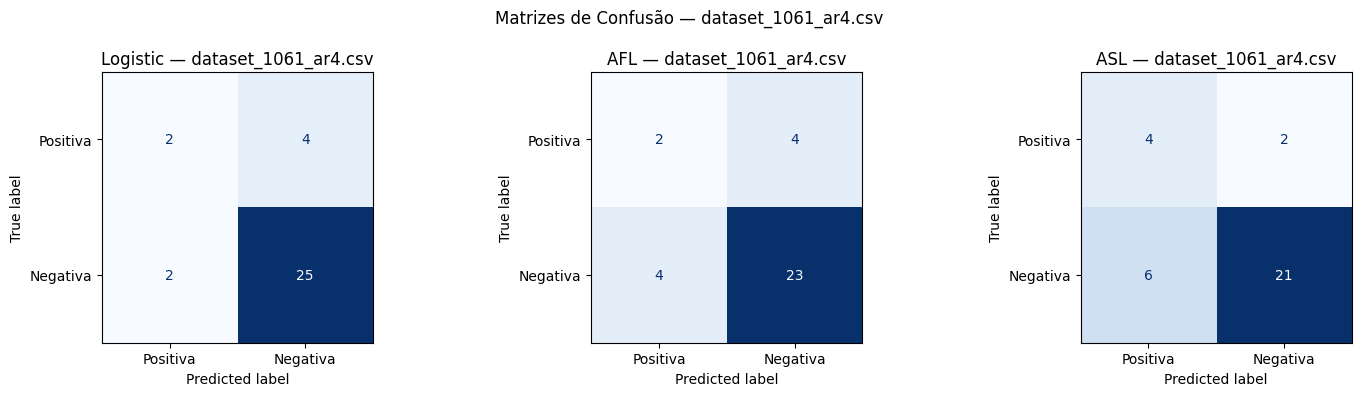

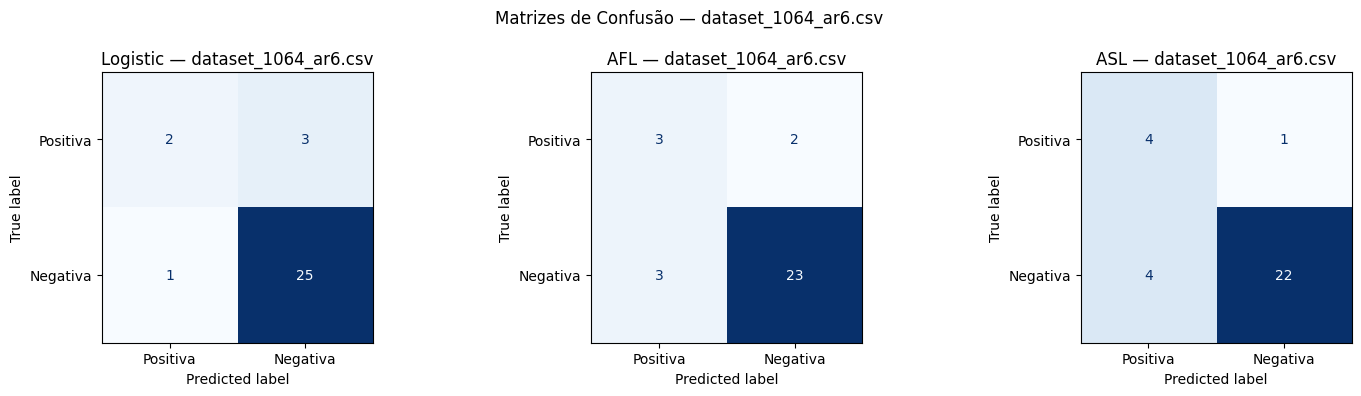

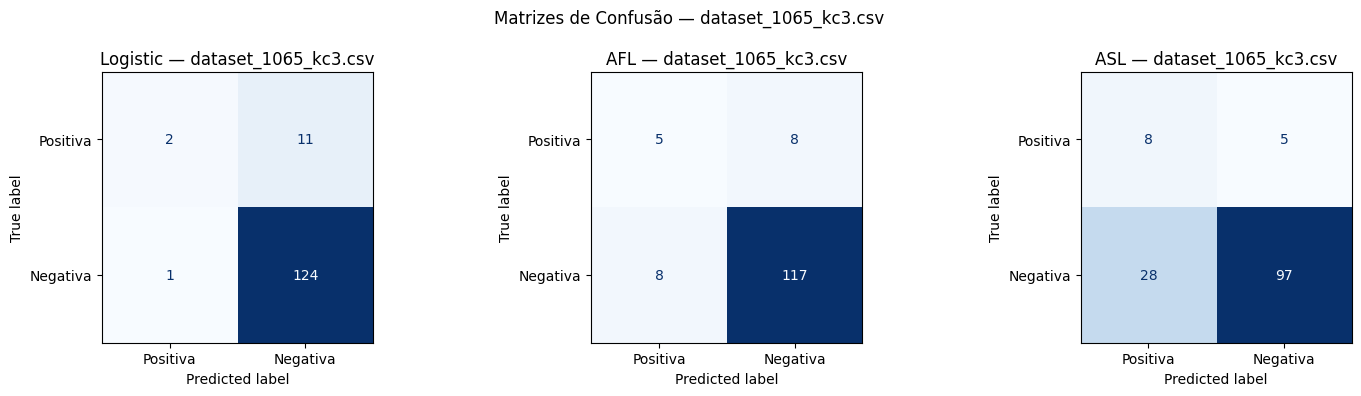

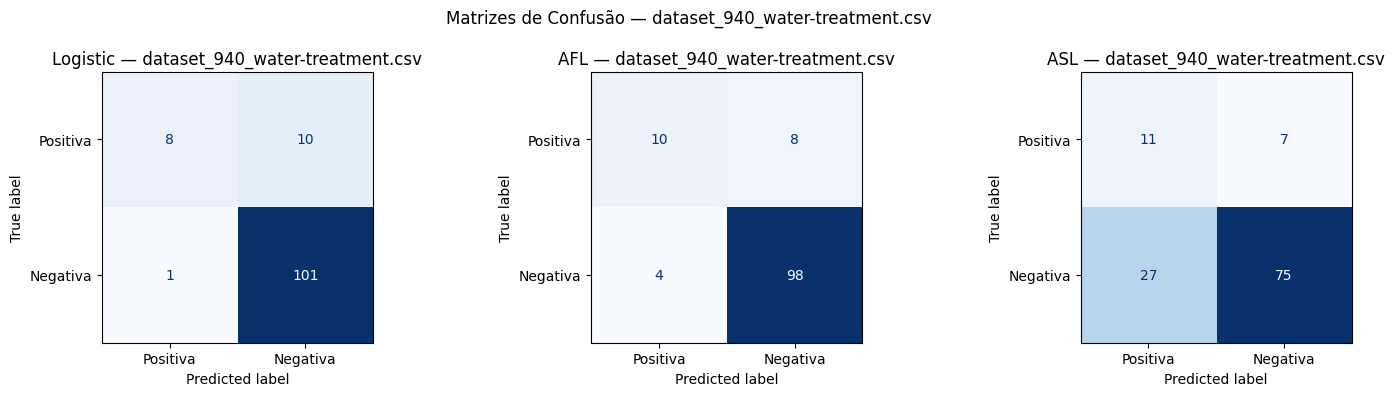

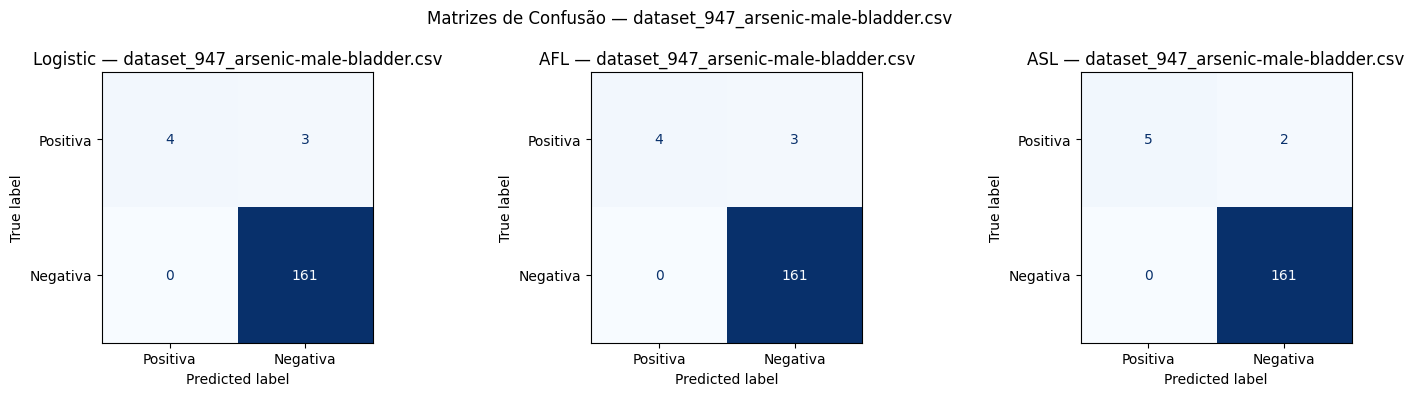

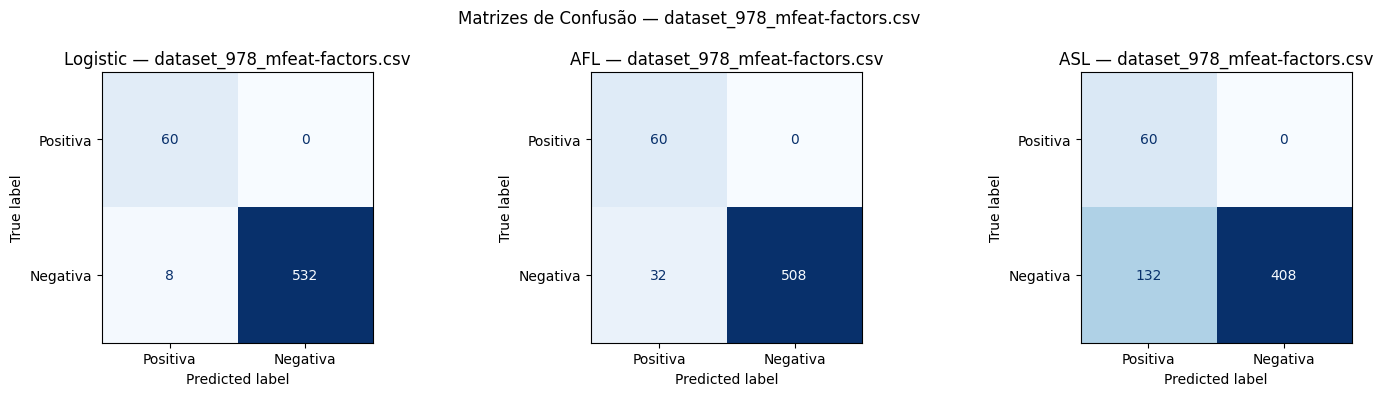

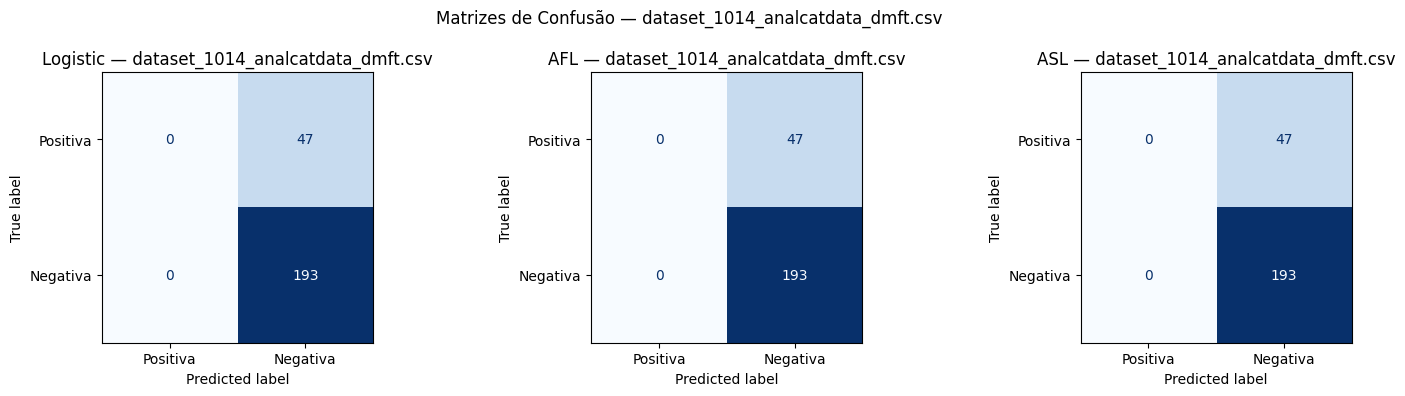

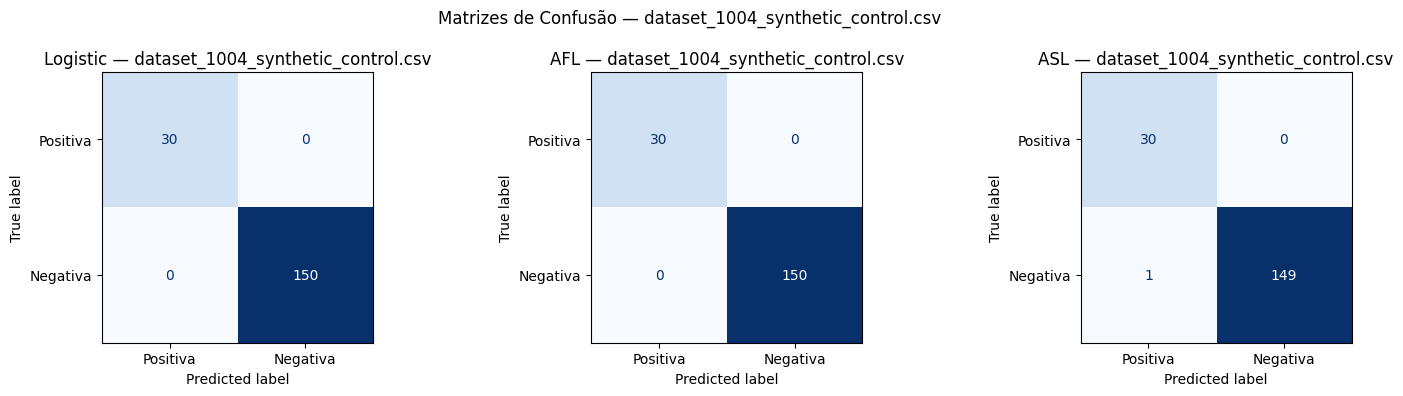

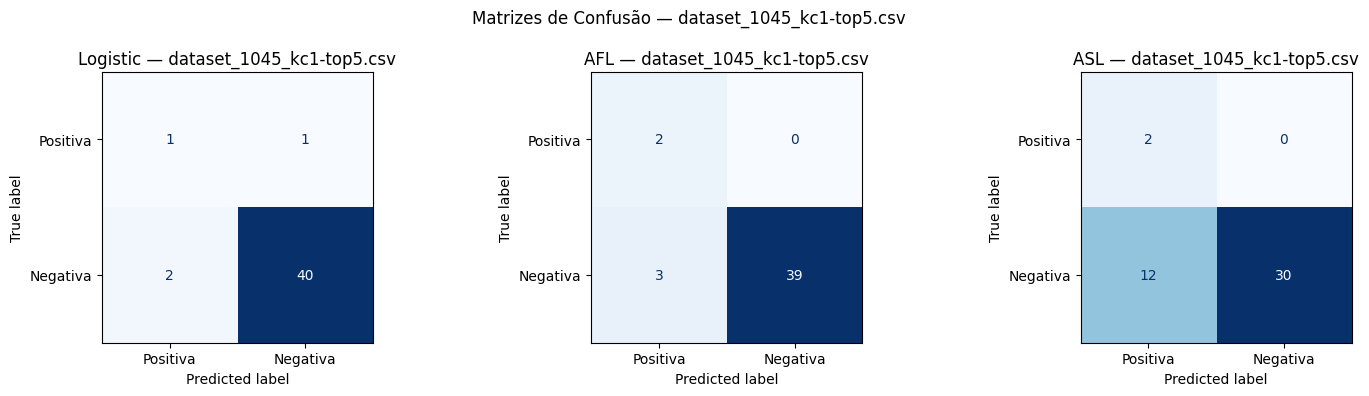

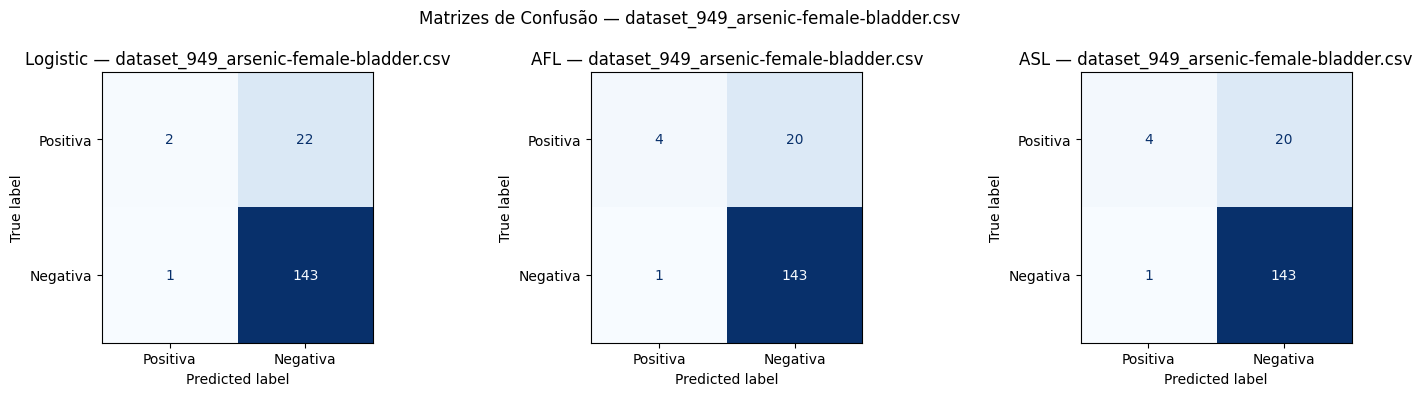

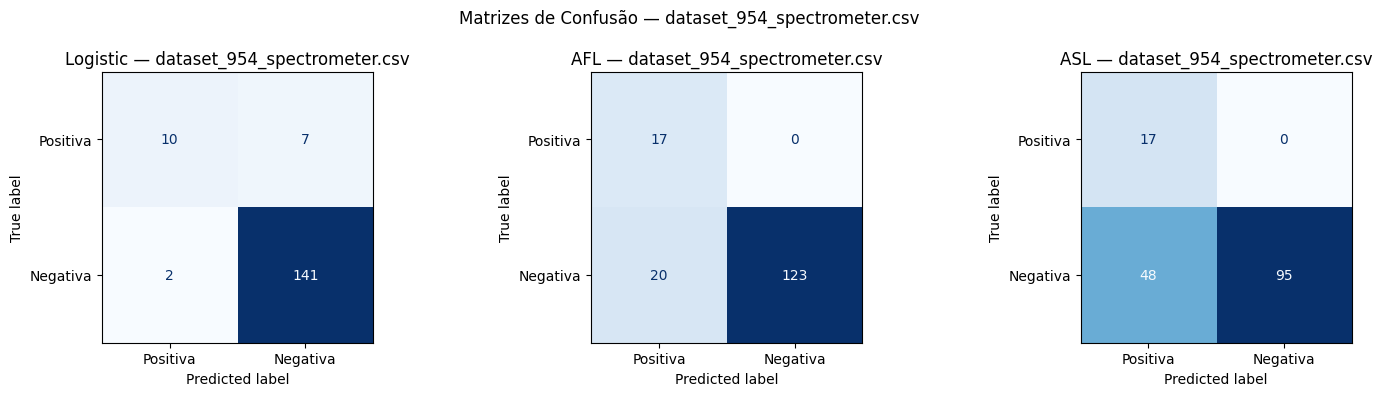

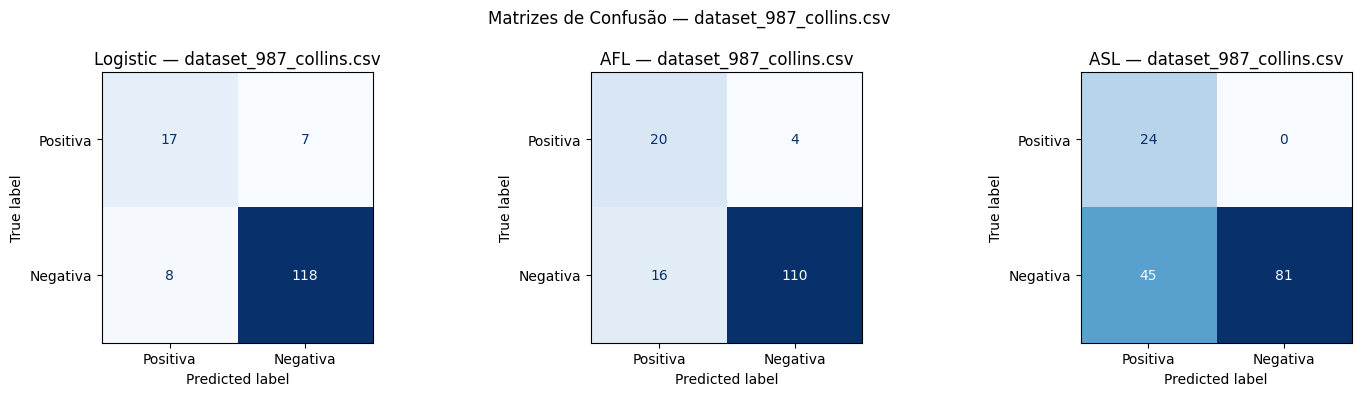

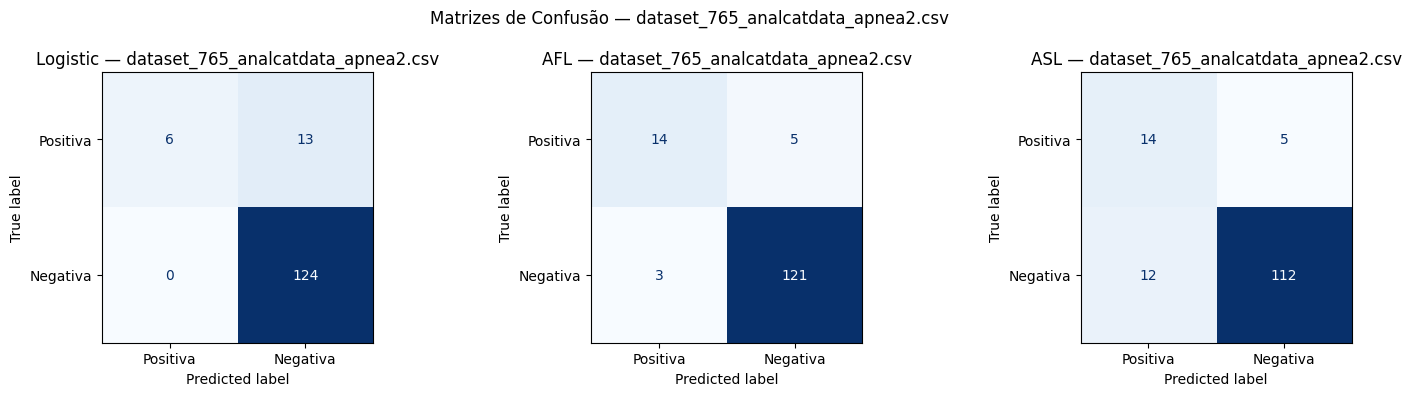

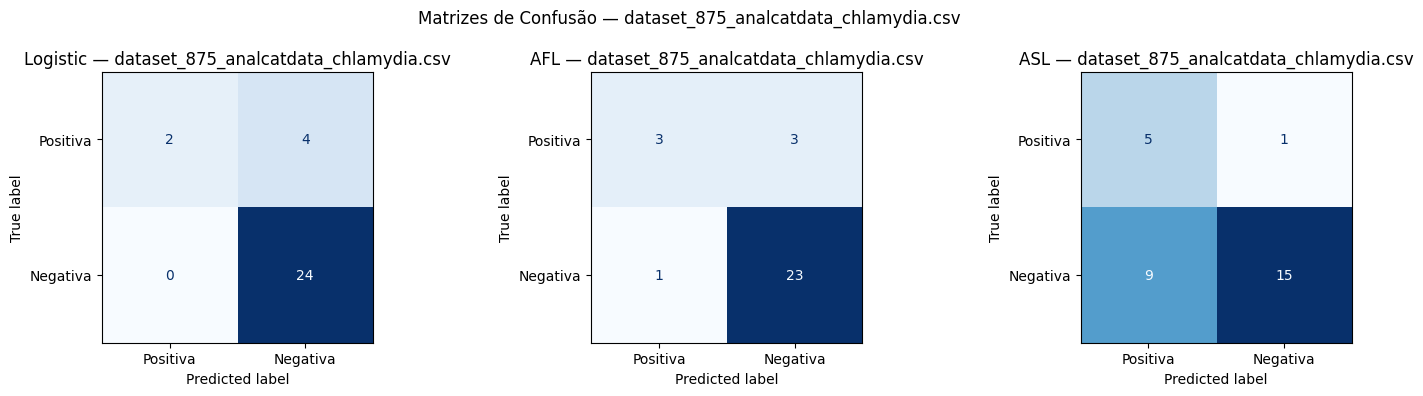

In [ ]:
import os
import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Lista dos arquivos dos datasets disponíveis para análise
datasets_disponiveis = [
    "dataset_1056_mc1.csv", "dataset_951_arsenic-male-lung.csv", "dataset_950_arsenic-female-lung.csv",
    "dataset_1049_pc4.csv", "dataset_1050_pc3.csv", "dataset_1059_ar1.csv",
    "dataset_1061_ar4.csv", "dataset_1064_ar6.csv", "dataset_1065_kc3.csv",
    "dataset_940_water-treatment.csv", "dataset_947_arsenic-male-bladder.csv",
    "dataset_978_mfeat-factors.csv", "dataset_1014_analcatdata_dmft.csv",
    "dataset_1004_synthetic_control.csv", "dataset_1045_kc1-top5.csv",
    "dataset_949_arsenic-female-bladder.csv", "dataset_954_spectrometer.csv",
    "dataset_987_collins.csv", "dataset_765_analcatdata_apnea2.csv",
    "dataset_875_analcatdata_chlamydia.csv"
]

base_path = "./class_imbalance"
summary = []
curvas_roc_por_dataset = {}
matrizes_confusao_por_dataset = {}

for dataset_name in datasets_disponiveis:
    try:
        df = pd.read_csv(os.path.join(base_path, dataset_name)).dropna()

        possible_targets = ["target", "class", "label", "Class", "response", "c", "defects", "binaryClass", "DL"]
        target_col = next((col for col in df.columns if col in possible_targets), None)
        if target_col is None:
            raise ValueError("Coluna-alvo não encontrada")

        y = df[target_col]
        X = df.drop(columns=[target_col])

        # Garantir que classe 1 é a minoria
        y = y.astype(str)
        counts = y.value_counts()
        classes = counts.index.tolist()
        if len(classes) != 2:
            raise ValueError("Dataset não binário")

        if counts[classes[0]] < counts[classes[1]]:
            minority_class, majority_class = classes[0], classes[1]
        else:
            minority_class, majority_class = classes[1], classes[0]

        y = y.map({majority_class: 0, minority_class: 1})

        X = pd.get_dummies(X, drop_first=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)

        modelos = {
            "Logistic": SimpleLogisticRegression(lr=0.01),
            "AFL": LogisticRegressionAFL(lr=0.01, gamma_pos=2.0, gamma_neg=0.5, alpha=0.75),
            "ASL": LogisticRegressionASL(lr=0.001, gamma_pos=2, gamma_neg=1, alpha=0.75)
        }

        curvas_roc_por_dataset[dataset_name] = {}
        matrizes_confusao_por_dataset[dataset_name] = {}

        for nome, model in modelos.items():
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            y_pred = (y_proba >= 0.5).astype(int)

            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            try:
                auc_val = roc_auc_score(y_test, y_proba)
            except:
                auc_val = None

            summary.append({
                "Dataset": dataset_name,
                "Modelo": nome,
                "Accuracy": report["accuracy"],
                "Recall (Macro)": report["macro avg"]["recall"],
                "F1-Score (Macro)": report["macro avg"]["f1-score"],
                "AUC": auc_val
            })

            try:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                curvas_roc_por_dataset[dataset_name][nome] = (fpr, tpr, auc(fpr, tpr))
            except:
                pass

            try:
                cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
                matrizes_confusao_por_dataset[dataset_name][nome] = cm
            except:
                pass

    except Exception as e:
        summary.append({
            "Dataset": dataset_name,
            "Modelo": "Erro",
            "Accuracy": None,
            "Recall (Macro)": None,
            "F1-Score (Macro)": None,
            "AUC": None,
            "Erro": str(e)
        })
        print(f"⚠️ Erro ao processar {dataset_name}: {e}")

# Construir DataFrame com os resultados
df_summary = pd.DataFrame(summary)

# --- VISUALIZAÇÃO ---

# Renomear modelos para apresentação
df_summary["Modelo"] = df_summary["Modelo"].replace({
    "Logistic": "Original",
    "Focal": "AFL",
    "ASL": "ASL"
})

# Exibir todas as métricas por dataset e modelo
print("📋 Resultados por dataset e modelo:")
display(df_summary[["Dataset", "Modelo", "Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]])

# Exibir médias por modelo
print("📊 Médias por modelo:")
medias_por_modelo = df_summary.groupby("Modelo")[["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]].mean().round(4)
display(medias_por_modelo)

# Curvas ROC
print("📈 Curvas ROC por dataset:")
for dataset, curvas in curvas_roc_por_dataset.items():
    plt.figure()
    for modelo, (fpr, tpr, auc_val) in curvas.items():
        plt.plot(fpr, tpr, label=f"{modelo} (AUC = {auc_val:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC — {dataset}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Matrizes de confusão
print("🧩 Matrizes de confusão por dataset:")
for dataset, matrizes in matrizes_confusao_por_dataset.items():
    modelos = list(matrizes.keys())
    fig, axs = plt.subplots(1, len(modelos), figsize=(5 * len(modelos), 4))
    if len(modelos) == 1:
        axs = [axs]
    for idx, modelo in enumerate(modelos):
        cm = matrizes[modelo]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positiva", "Negativa"])
        disp.plot(ax=axs[idx], cmap="Blues", colorbar=False)
        axs[idx].set_title(f"{modelo} — {dataset}")
    plt.suptitle(f"Matrizes de Confusão — {dataset}")
    plt.tight_layout()
    plt.show()


## 📈 Comparação Detalhada por Métrica

Os gráficos abaixo mostram a comparação entre os três modelos (**Original**, **AFL**, **ASL**) em cada uma das quatro métricas avaliadas:

- **Accuracy**: Mede a proporção total de classificações corretas;
- **Recall (Macro)**: Dá igual peso a ambas as classes, avaliando a capacidade do modelo de identificar cada uma;
- **F1-Score (Macro)**: Balanceia precisão e recall de forma equitativa para ambas as classes;
- **AUC**: Reflete a capacidade discriminativa do modelo em termos probabilísticos.

Estes gráficos permitem observar **como cada função de perda influencia o desempenho global do modelo** em diferentes cenários de desbalanceamento.



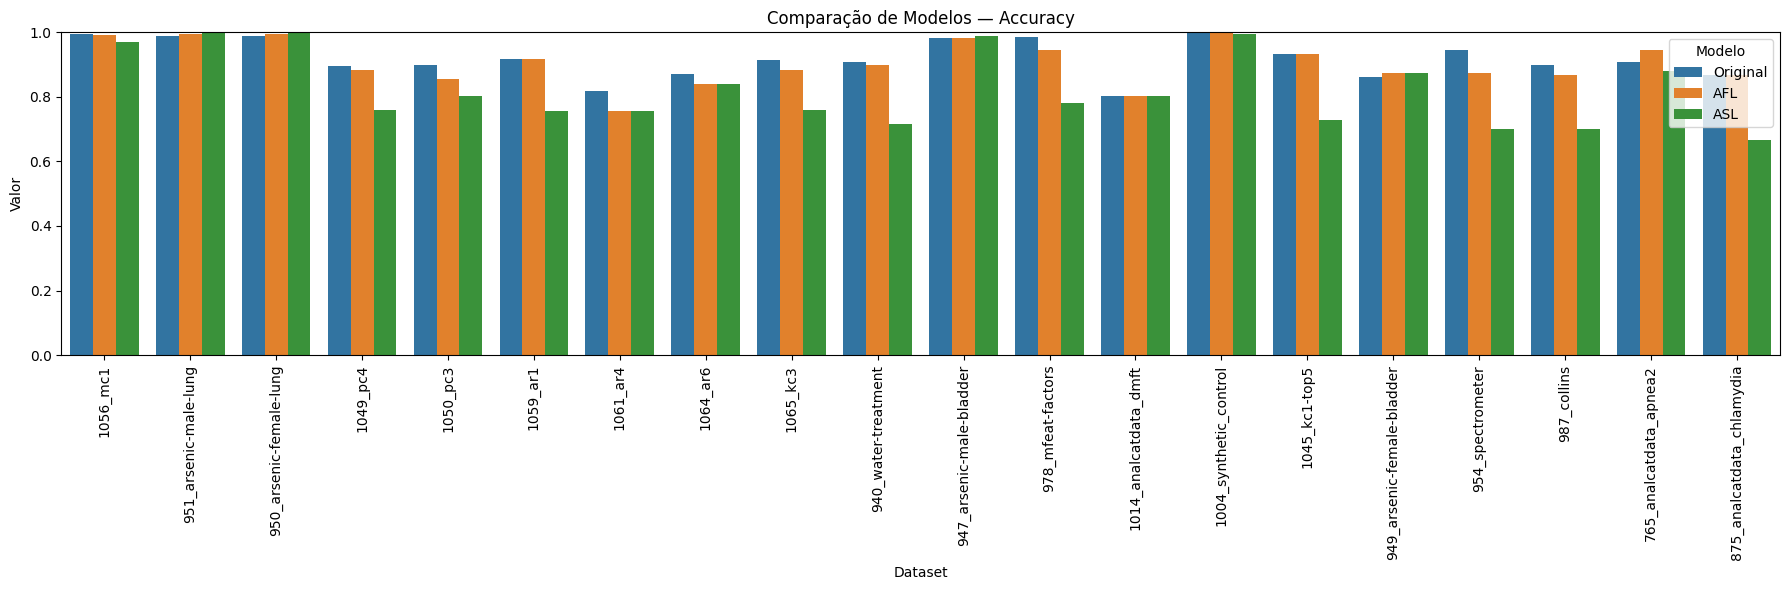

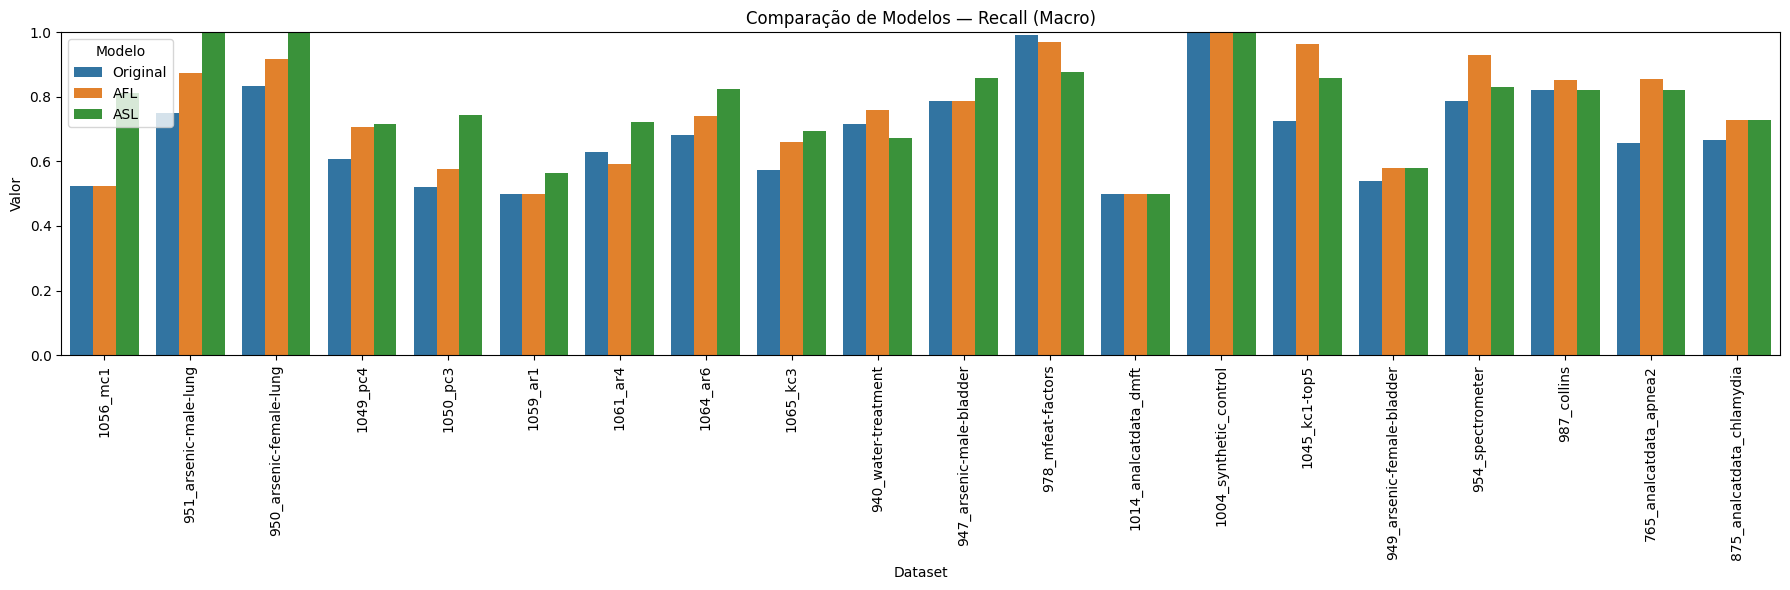

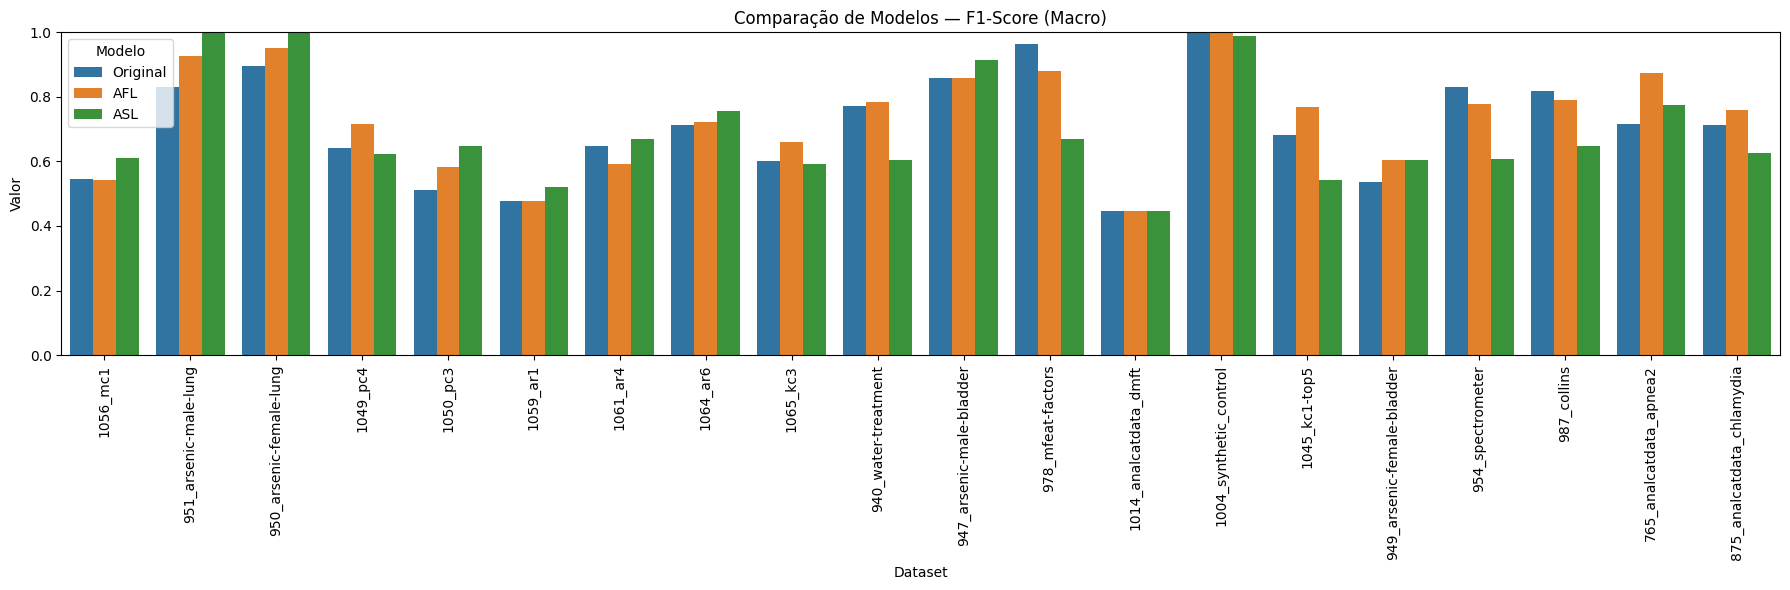

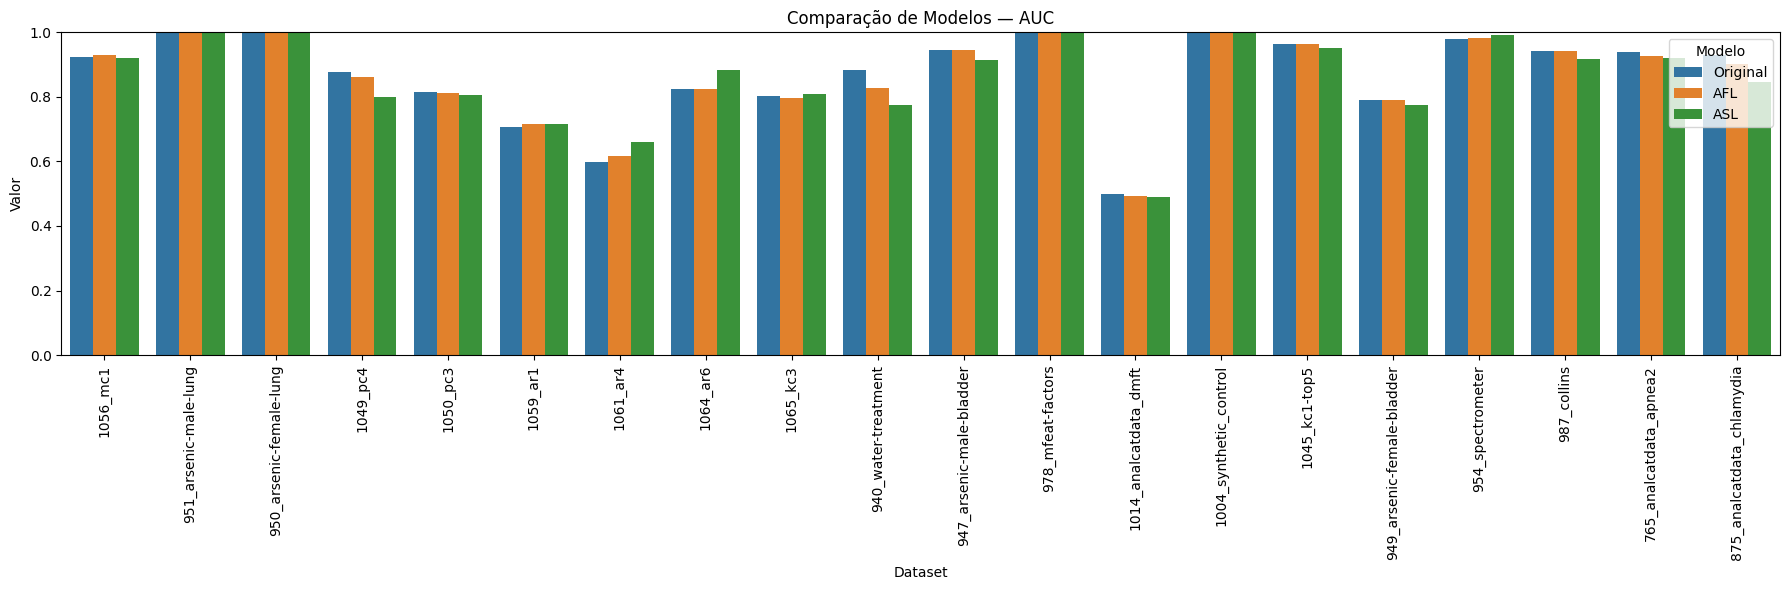

In [ ]:
# Garantir dados válidos
df_plot = df_summary[df_summary["Modelo"] != "Erro"].copy()
df_plot["Dataset"] = df_plot["Dataset"].str.replace("dataset_", "").str.replace(".csv", "")

# Reorganizar para gráfico
df_melt_all = df_plot.melt(
    id_vars=["Dataset", "Modelo"], 
    value_vars=["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"],
    var_name="Métrica", value_name="Valor"
)

# Plot separado por métrica
metricas = df_melt_all["Métrica"].unique()

for metrica in metricas:
    plt.figure(figsize=(18, 6))
    sns.barplot(
        data=df_melt_all[df_melt_all["Métrica"] == metrica],
        x="Dataset",
        y="Valor",
        hue="Modelo"
    )
    plt.title(f"Comparação de Modelos — {metrica}")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

## 🧠 Análise Comparativa dos Resultados

A análise gráfica revela tendências claras no comportamento dos modelos:

- O modelo **Original** apresenta *accuracy* geralmente alta, mas falha consistentemente em métricas mais sensíveis ao desbalanceamento, como o *Recall Macro* e o *F1-Score Macro*;
- O modelo com **Asymmetric Focal Loss (AFL)** melhora o equilíbrio entre precisão e recall, especialmente nos datasets mais desbalanceados, com ganhos visíveis em F1-score;
- O modelo com **Asymmetric Loss (ASL)** destaca-se no *Recall Macro*, mostrando a sua eficácia em capturar a classe minoritária, mesmo à custa de uma leve redução na *accuracy*.

Esses resultados confirmam que as modificações introduzidas nas funções de perda foram eficazes para mitigar os efeitos negativos do desbalanceamento, **aumentando a justiça do modelo sem comprometer severamente o desempenho geral**.


## 🎯 Foco no F1-score Macro

Como o desbalanceamento de classes afeta diretamente a capacidade do modelo em equilibrar precisão e recall, o **F1-score macro** torna-se a métrica mais relevante. Ele avalia o desempenho médio entre as classes, sem favorecer a classe majoritária, sendo particularmente útil em contextos onde a detecção da minoria é crítica.
 

## 📊 Desempenho Médio por Modelo

A tabela abaixo apresenta as **médias das métricas principais** (Accuracy, Recall macro, F1-score macro e AUC) para os três modelos avaliados nos 20 datasets desbalanceados.

Observações principais:

- A **Regressão Logística Original** obteve a maior *accuracy* média (91.91%), mas teve o **pior desempenho em recall e F1-score macro**, revelando forte viés para a classe majoritária.
- A versão com **Asymmetric Focal Loss (AFL)** apresentou o **melhor equilíbrio geral**, com a maior média de *F1-score macro* (73.58%) e *recall macro* competitivo, mantendo alta *accuracy* e *AUC*.
- A versão com **Asymmetric Loss (ASL)** destacou-se por alcançar o **maior recall macro** (78.10%), evidenciando forte capacidade de identificar a classe minoritária, embora com uma **queda notável de acurácia** (82.40%).

Esses resultados reforçam a eficácia das **funções de perda assimétricas** na mitigação dos efeitos do desbalanceamento. Enquanto o **AFL se mostra mais equilibrado**, o **ASL é útil quando o foco é maximizar a cobertura da minoria**, mesmo sacrificando desempenho global



In [ ]:
# Cálculo das médias das métricas por modelo (somente onde não houve erro)
df_resumo = df_summary[df_summary["Modelo"] != "Erro"].copy()

# Garantir que os nomes dos modelos estejam consistentes
# e ordenar os modelos para facilitar comparação
modelo_order = ["Original", "AFL", "ASL"]
df_resumo["Modelo"] = pd.Categorical(df_resumo["Modelo"], categories=modelo_order, ordered=True)

# Agrupar por modelo e calcular a média das métricas
medias_por_modelo = (
    df_resumo
    .groupby("Modelo")[["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]]
    .mean()
    .round(4)
)

# Exibir resultados
display(medias_por_modelo)

/var/folders/fx/92b2vtzs0d30lkd7wvr1fb_80000gn/T/ipykernel_28920/1128433439.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Modelo")[["Accuracy", "Recall (Macro)", "F1-Score (Macro)", "AUC"]]


,Accuracy,Recall (Macro),F1-Score (Macro),AUC
Modelo,,,,
Original,0.9191,0.6906,0.7101,0.8709
AFL,0.9056,0.7511,0.7358,0.8666
ASL,0.8240,0.7810,0.6920,0.8590


## 📈 Análise Crítica: AUC = 1.0 em Datasets Extremamente Desbalanceados

Durante a avaliação empírica, observou-se que em **alguns datasets altamente desbalanceados**, como `arsenic-male-lung`, os modelos — incluindo os ajustados com **AFL (Asymmetric Focal Loss)** e **ASL (Asymmetric Loss)** — apresentaram uma **AUC igual a 1.0**.

Embora esse valor represente, em teoria, uma separação perfeita entre classes, é importante interpretá-lo com cautela:

- Nestes casos, a **classe minoritária representa menos de 3% dos dados**, tornando possível que o modelo acerte todos os exemplos positivos por sorte ou por uma separabilidade clara nos dados;
- A métrica **AUC** avalia apenas a **ordenação dos scores**: se todas as instâncias da classe positiva recebem probabilidades maiores do que todas as da classe negativa, o AUC será 1 — **mesmo que o modelo esteja mal calibrado ou classifique mal com o threshold padrão (0.5)**;
- Isso explica por que, **mesmo após modificações com AFL e ASL**, o valor de AUC permaneceu inalterado em relação ao modelo base.

⚠️ Esses casos **não invalidam os ajustes propostos**, mas revelam limitações importantes do uso exclusivo do AUC em cenários extremos. Modelos com AUC = 1 ainda podem apresentar:

- **Recall ou F1-score muito baixos**, se o threshold de decisão não estiver adequado;
- **Capacidade de generalização limitada**, sobretudo quando o número de instâncias positivas é demasiado reduzido para permitir inferência estatística confiável.

---

### 💡 Sugestões para Investigações Futuras

Com base nesta análise, algumas direções promissoras para trabalhos futuros incluem:

- **Ajuste dinâmico do limiar de decisão**, de modo a otimizar diretamente métricas como *F1-score* ou *balanced accuracy*;
- **Utilização de intervalos de confiança para o AUC**, especialmente em datasets com classes extremamente raras;
- **Ampliação do conjunto de datasets**, de forma a validar se este comportamento se repete ou se é um artefacto específico de alguns casos.

Estas sugestões podem tornar a análise ainda mais robusta e ajudar a compreender melhor os desafios impostos por cenários de desbalanceamento extremo.


## 🔍 Considerações Finais

A análise dos resultados médios dos três modelos avaliados nos 20 datasets desbalanceados revela padrões consistentes:

- A **regressão logística original** apresentou a maior *accuracy* (**91.91%**), mas teve o **pior desempenho em recall e F1-score macro**, confirmando seu viés para a classe maioritária — ou seja, acerta bastante no geral, mas ignora a minoria.

- A variante com **Asymmetric Focal Loss (AFL)** apresentou o **melhor equilíbrio entre *accuracy* (**90.56%**) e F1-score macro (**73.58%**)**, além de um recall macro elevado (**75.11%**) — tornando-se a opção mais balanceada entre desempenho geral e sensibilidade à minoria.

- A **Asymmetric Loss (ASL)** destacou-se por alcançar o **maior recall macro (**78.10%**)**, evidenciando alta sensibilidade à classe minoritária. No entanto, teve a **menor acurácia (**82.40%**) e F1 macro (**69.20%**)**, indicando um sacrifício da precisão geral em prol da detecção da minoria.

---

Esses resultados reforçam que **modificações na função de perda** são estratégias eficazes em cenários de desbalanceamento. Ambas as variantes superam o viés da regressão logística simples, cada uma com seu foco:

- **AFL** se destaca como um **modelo equilibrado**, ideal quando queremos boa performance global e proteção da minoria.
- **ASL** é preferível quando o foco é **maximizar o recall da classe minoritária**, mesmo sacrificando acurácia.

Tais abordagens mantêm a simplicidade e interpretabilidade dos modelos lineares, sendo especialmente úteis em contextos críticos como **medicina**, **fraude** ou **segurança** — onde **errar a minoria pode custar caro**.
